# Custom CGCNN (Crystal Graph Convolutional Neural Network) with Regression (energy_per_atom) for SrTiO3 

1. SrTiO3의 Ti 원자의 유닛셀 안에서의 위치를 변화시키며 이에 따른 energy per atom 물성값의 변화 곡선 그리기를 시도
2. 모델이 제대로 예측한다면 DFT 결과와 모델의 추론값이 유사해야 한다.
3. 모델의 예측값에 대하여 normalizer.denorm(prediction)을 반드시 할 것!!




## Google Drive Mount



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/
%ls -l

/content/drive/MyDrive
total 16
drwx------ 2 root root 4096 Oct 14  2020 '00. Github'/
drwx------ 2 root root 4096 Nov  6  2020 '01. Backup Files'/
drwx------ 2 root root 4096 Jan 20  2021  cgcnn/
drwx------ 2 root root 4096 Oct  1 14:07  Temp/


## CGCNN Github Repository Clone



In [ ]:
#!git clone https://github.com/txie-93/cgcnn

## Pymatgen Library Installation



In [ ]:
!pip install pymatgen==2020.11.11

In [ ]:
!pip list | grep imgaug
!pip list | grep pymatgen
!python --version

imgaug                        0.2.9
pymatgen                      2020.11.11
Python 3.7.12


## Change Directory to Dataset Root directory



In [ ]:
%cd /content/drive/MyDrive/cgcnn/data/material-data
%ls -l

/content/drive/MyDrive/cgcnn/data/material-data
total 294730
-rw------- 1 root root 125324329 Jan 22  2021 mp_data-27430.pickle
-rw------- 1 root root 175657265 Feb 25  2021 mp_data-46744.pickle
-rw------- 1 root root    291980 Jan 20  2021 mp-ids-27430.csv
-rw------- 1 root root     33332 Jan 20  2021 mp-ids-3402.csv
-rw------- 1 root root    494045 Jan 20  2021 mp-ids-46744.csv
-rw------- 1 root root       877 Jan 20  2021 README.md


## Material Project ID Collection

* cgcnn github repository에서 제공하는 46744개의 Material Project ID를 이용한다.



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
material_project_IDs = pd.read_csv('mp-ids-46744.csv', header = None)
material_project_IDs = np.array(material_project_IDs).reshape(-1)
print(material_project_IDs)
print('Number of Material Project IDs : {}'.format(len(material_project_IDs)))

['mp-754118' 'mp-978908' 'mp-633688' ... 'mp-755142' 'mp-648469' 'mp-2327']
Number of Material Project IDs : 46744


In [ ]:
# Sample check
material_project_IDs[2]

'mp-633688'

## Custom Dataset Generation

* 46744개의 Material Project IDs.csv 파일에서 **energy_per_atom**과 **structure** 정보를 읽어 data에 저장한다.



In [ ]:
from pymatgen.ext.matproj import MPRester
from tqdm import tqdm
import pickle
import time

In [ ]:
data = {}
my_API_key = 'I5DdZsmHO3er6WKz' # You can get your own API key from the homepage of material project

with MPRester(my_API_key) as m:

    for mp_id in tqdm(material_project_IDs):

        # Number of data : 46744 but valid 
        # Target Property : energy_per_atom
        data[mp_id] = (m.query(criteria = {'material_id' : mp_id},
                               properties = ['structure', 'energy_per_atom'])) # index : property 구조

        # To avoid MPResterError with status code 502
        time.sleep(0.5)

 23%|██▎       | 10722/46744 [2:23:30<7:41:17,  1.30it/s]

In [ ]:
len(data)

In [ ]:
# Save data 
with open('energy_per_atom_mp_ids_46744.pickle', 'wb') as fw:
    pickle.dump(data, fw)

In [ ]:
# 일단 예전에 저장된 pickle 데이터로 학습한다.

In [ ]:
# Load data
with open('mp_data-46744.pickle', 'rb') as fr:
    data = pickle.load(fr)

In [ ]:
# Sample check
data['mp-1000']

[{'energy_per_atom': -4.323689235, 'structure': Structure Summary
  Lattice
      abc : 5.013215958771575 5.013215958771575 5.013215958771575
   angles : 60.00000000000001 60.00000000000001 60.00000000000001
   volume : 89.09108390126052
        A : 0.0 3.544879 3.544879
        B : 3.544879 0.0 3.544879
        C : 3.544879 3.544879 0.0
  PeriodicSite: Ba (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
  PeriodicSite: Te (3.5449, 3.5449, 3.5449) [0.5000, 0.5000, 0.5000]}]

In [ ]:
# Custom Dataset으로 CGCNN을 작동시킬 경우, 실질적으로 2개의 데이터를 새로 생성해야 한다.
# 1. new_id_prop_data
# 2. new_crystal

In [ ]:
# 1. new_id_prop_data generation
new_id_prop_data = []
for cif_id, crystal_information in data.items():
    if crystal_information == []: # Unvalid cif ID의 경우, 비어있는 리스트를 return한다.
        pass
    else:
        new_id_prop_data.append([cif_id, crystal_information[0]['energy_per_atom']]) # cif id vs target property 구조

print('Number of real valid crystal data : {}'.format(len(new_id_prop_data)))

Number of real valid crystal data : 36832


In [ ]:
# 2. new_crystal generation
idx = 2 # index를 지정하면
cif_id, target = new_id_prop_data[idx] # 전체 데이터 중 index에 대응하는 cif id와 target property에 접근가능한 구조
print('cif_id : {}'.format(cif_id))
print('target : {}'.format(target))

cif_id : mp-3799
target : -9.681103753333334


In [ ]:
new_crystal_structure = data[cif_id][0]['structure'] # 위에서 정한 index에 의해 자동으로 cif_id 특정됨.
new_crystal_structure

Structure Summary
Lattice
    abc : 3.849352 3.849352 6.919488
 angles : 90.0 90.0 90.0
 volume : 102.5295883081959
      A : 3.849352 0.0 0.0
      B : 0.0 3.849352 0.0
      C : 0.0 0.0 6.919488
PeriodicSite: Gd (0.0000, 1.9247, 5.3246) [0.0000, 0.5000, 0.7695]
PeriodicSite: Gd (1.9247, 0.0000, 1.5948) [0.5000, 0.0000, 0.2305]
PeriodicSite: S (1.9247, 0.0000, 4.4577) [0.5000, 0.0000, 0.6442]
PeriodicSite: S (0.0000, 1.9247, 2.4618) [0.0000, 0.5000, 0.3558]
PeriodicSite: F (1.9247, 1.9247, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: F (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

## **cgcnn/cgcnn/data.py**



In [ ]:
from __future__ import print_function, division
import csv
import functools
import json
import os
import random
import warnings

import numpy as np
import torch
from pymatgen.core.structure import Structure
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler

### get_train_val_test_loader



In [ ]:
def get_train_val_test_loader(dataset, collate_fn = default_collate,
                              batch_size = 64, train_ratio = None,
                              val_ratio = 0.1, test_ratio = 0.1, return_test = False,
                              num_workers = 1, pin_memory = False, **kwargs):
    """
    Utility function for dividing a dataset to train, val, test datasets.

    !!! The dataset needs to be shuffled before using the function !!!

    Parameters
    ----------
    dataset : torch.utils.data.Dataset
              The full dataset to be divided.
    collate_fn : torch.utils.data.DataLoader
    batch_size : int
    train_ratio : float
    val_ratio : float
    test_ratio : float
    return_test : bool
                  Whether to return the test dataset loader. 
                  If False, the last test_size data will be hidden.
    num_workers : int
    pin_memory : bool

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
                   DataLoader that random samples the training data.
    val_loader : torch.utils.data.DataLoader
                 DataLoader that random samples the validation data.
    (test_loader) : torch.utils.data.DataLoader
                    DataLoader that random samples the test data, returns if return_test = True.
    """
    total_size = len(dataset) # Number of total data

    if kwargs['train_size'] is None:
        if train_ratio is None:
            assert val_ratio + test_ratio < 1
            train_ratio = 1 - val_ratio - test_ratio
            print('[Warning] train_ratio is None, using 1 - val_ratio - test_ratio = {} as training data.'.format(train_ratio))
        else:
            assert train_ratio + val_ratio + test_ratio <= 1

    indices = list(range(total_size)) # Index list of total data

    if kwargs['train_size']:
        train_size = kwargs['train_size']
    else:
        train_size = int(train_ratio * total_size)

    if kwargs['test_size']:
        test_size = kwargs['test_size']
    else:
        test_size = int(test_ratio * total_size)

    if kwargs['val_size']:
        valid_size = kwargs['val_size']
    else:
        valid_size = int(val_ratio * total_size)

    # Random sampler for training, validation dataset
    train_sampler = SubsetRandomSampler(indices = indices[:train_size]) 
    val_sampler   = SubsetRandomSampler(indices = indices[ -(valid_size + test_size) : -test_size ])

    if return_test: # Test data loader를 사용하는 경우
        test_sampler = SubsetRandomSampler(indices = indices[-test_size:])

    train_loader = DataLoader(dataset, batch_size = batch_size,
                              sampler = train_sampler,
                              num_workers = num_workers,
                              collate_fn = collate_fn, pin_memory = pin_memory)
    val_loader = DataLoader(dataset, batch_size = batch_size,
                            sampler = val_sampler,
                            num_workers = num_workers,
                            collate_fn = collate_fn, pin_memory = pin_memory)
    
    if return_test: # Test data loader를 사용하는 경우
        test_loader = DataLoader(dataset, batch_size = batch_size,
                                 sampler = test_sampler,
                                 num_workers = num_workers,
                                 collate_fn = collate_fn, pin_memory = pin_memory)  
        
    if return_test: # Test data loader를 사용하는 경우
        return train_loader, val_loader, test_loader
    else:
        return train_loader, val_loader

### collate_pool



In [ ]:
def collate_pool(dataset_list):
    """
    Collate a list of data and return a batch for predicting crystal properties.
    (Crystal Graph data에 대한 Graph batch를 생성하는 함수)

    Parameters
    ----------

    dataset_list : list of tuples for each data point.
                   (atom_fea, nbr_fea, nbr_fea_idx, target)
                   
                   atom_fea : torch.Tensor shape (n_i, atom_fea_len)
                   nbr_fea : torch.Tensor shape (n_i, M, nbr_fea_len)
                   nbr_fea_idx : torch.LongTensor shape (n_i, M)
                   target : torch.Tensor shape (1, )
                   cif_id : str or int

    Returns
    -------
    N = sum(n_i); N0 = sum(i)

    batch_atom_fea : torch.Tensor shape (N, orig_atom_fea_len)
                     Atom features from atom type
    batch_nbr_fea : torch.Tensor shape (N, M, nbr_fea_len)
                    Bond features of each atom's M neighbors
    batch_nbr_fea_idx : torch.LongTensor shape (N, M)
                        Indices of M neighbors of each atom
    crystal_atom_idx : list of torch.LongTensor of length N0
                       Mapping from the crystal idx to atom idx
    target : torch.Tensor shape (N, 1)
             Target value for prediction
    batch_cif_ids : list
    """
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    batch_cif_ids = []
    base_idx = 0

    for i, ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id) in enumerate(dataset_list):

        n_i = atom_fea.shape[0]  # Number of atoms for this crystal
        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx + base_idx)

        new_idx = torch.LongTensor(np.arange(n_i) + base_idx)

        crystal_atom_idx.append(new_idx)
        batch_target.append(target)
        batch_cif_ids.append(cif_id)
        base_idx += n_i

    return (torch.cat(batch_atom_fea, dim = 0),
            torch.cat(batch_nbr_fea, dim = 0),
            torch.cat(batch_nbr_fea_idx, dim = 0),
            crystal_atom_idx), \
            torch.stack(batch_target, dim = 0), \
            batch_cif_ids

### GaussianDistance



In [ ]:
class GaussianDistance(object):
    """
    Expands the distance by Gaussian basis. (원자 사이의 거리(distance)를 Gaussian basis로 확장하는 클래스)

    Unit : Angstrom
    """
    def __init__(self, dmin, dmax, step, var = None):
        """
        Parameters
        ----------

        dmin : float
               Minimum interatomic distance
        dmax : float
               Maximum interatomic distance
        step : float
               Step size for the Gaussian filter
        """
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax + step, step)
        if var is None:
            var = step
        self.var = var 

    def expand(self, distances):
        """
        Apply Gaussian distance filter to a numpy distance array

        Parameters
        ----------

        distance : np.array shape n-d array
                   A distance matrix of any shape
        
        Returns
        -------
        expanded_distance : shape (n+1)-d array
                            Expanded distance matrix with the last dimension of length len(self.filter)
        """
        return np.exp( -(distances[..., np.newaxis] - self.filter)**2 / self.var**2 )

### AtomInitializer



In [ ]:
class AtomInitializer(object):
    """
    Base class for initializing the vector representation for atoms.

    !!! Use one AtomInitializer per dataset !!!
    """
    def __init__(self, atom_types):
        self.atom_types = set(atom_types) # set(집합)으로 중복된 atom type 있으면 제거
        self._embedding = {}

    def get_atom_fea(self, atom_type):    # atom type에 따른 initial vector representation을 return하는 method
        assert atom_type in self.atom_types 
        return self._embedding[atom_type]

    def load_state_dict(self, state_dict):
        self._embedding = state_dict
        self.atom_types = set(self._embedding.keys())
        self._decodedict = {idx : atom_type for atom_type, idx in self._embedding.items()}

    def state_dict(self):
        return self._embedding

    def decode(self, idx):
        if not hasattr(self, '_decodedict'):
            self._decodedict = {idx : atom_type for atom_type, idx in self._embedding.items()}
        return self._decodedict[idx]

### AtomCustomJSONInitializer



In [ ]:
class AtomCustomJSONInitializer(AtomInitializer):
    """
    Initialize atom feature vectors using a JSON file, which is a python
    dictionary mapping from element number to a list representing the
    feature vector of the element.

    Parameters
    ----------

    elem_embedding_file : str
                          The path to the .json file
    """
    def __init__(self, elem_embedding_file):
        with open(elem_embedding_file) as f: # JSON file open
            elem_embedding = json.load(f)    # Load JSON file contents
        elem_embedding = {int(key) : value for key, value in elem_embedding.items()} # string key(atomic number) -> integer
        atom_types = set(elem_embedding.keys()) # set(집합)으로 중복된 atom number 있으면 제거 : 원자번호 1번 ~ 100번까지 나열
        super(AtomCustomJSONInitializer, self).__init__(atom_types)
        for key, value in elem_embedding.items():
            self._embedding[key] = np.array(value, dtype = float) # atomic number에 따른 value를 np.array로 embedding 속성에 저장

### CIFData



In [ ]:
class CIFData(Dataset): # Torch의 Custom Dataset 클래스를 작성하는 전형적인 방법
    """
    The CIFData dataset is a wrapper for a dataset where the crystal structures
    are stored in the form of CIF files. The dataset should have the following 
    directory structure:

    root_dir
    ├── id_prop.csv
    ├── atom_init.json
    ├── id0.cif
    ├── id1.cif
    ├── ...

    id_prop.csv : a CSV file with two columns. The first column recodes a 
    unique ID for each crystal, and the second column recodes the value of
    target property.

    atom_init.json : a JSON file that stores the initialization vector for each element.

    ID.cif : a CIF file that recodes the crystal structure, where ID is the
    unique ID for the crystal.

    Parameters
    ----------

    root_dir : str
               The path to the root directory of the dataset
    max_num_nbr : int
                  The maximum number of neighbors while constructing the crystal graph
    radius : float
             The cutoff radius for searching neighbors
    dmin : float
           The minimum distance for constructing GaussianDistance
    step : float
           The step size for constructing GaussianDistance
    random_seed : int
                  Random seed for shuffling the dataset

    Returns
    -------

    atom_fea : torch.Tensor shape (n_i, atom_fea_len)
    nbr_fea : torch.Tensor shape (n_i, M, nbr_fea_len)
    nbr_fea_idx : torch.LongTensor shape (n_i, M)
    target : torch.Tensor shape (1, )
    cif_id : str or int
    """
    def __init__(self, root_dir, max_num_nbr = 12, radius = 8, dmin = 0, step = 0.2,
                 random_seed = 123):
        self.root_dir = root_dir
        self.max_num_nbr, self.radius = max_num_nbr, radius
        assert os.path.exists(root_dir), 'root_dir does not exist!'

        id_prop_file = os.path.join(self.root_dir, 'id_prop.csv') # Custom dataset을 사용할 경우 root directory에 데이터는 없지만, atom_init.json 파일은 필요하므로 지정해야 한다.
        assert os.path.exists(id_prop_file), 'id_prop.csv does not exist!' # 이 부분은 Custom dataset을 사용할 경우 필요는 없으나 형식적으로 그냥 남겨둔다.

        with open(id_prop_file) as f:
            reader = csv.reader(f)
        #    self.id_prop_data = [row for row in reader]
        # ------------------------------------------------------------------------------------------------------------
        self.id_prop_data = new_id_prop_data # 위에서 정의한 Custom crystal dataset - new_id_prop_data 직접입력해야 한다!!
        # ------------------------------------------------------------------------------------------------------------

        random.seed(random_seed)          # Random Seed 설정
        random.shuffle(self.id_prop_data) # Random Shuffling 

        atom_init_file = os.path.join(self.root_dir, 'atom_init.json') # root directory를 남겨두어야 하는 중요한 이유 - 원자 초기화 JSON 파일
        assert os.path.exists(atom_init_file), 'atom_init.json file does not exist!'

        self.ari = AtomCustomJSONInitializer(atom_init_file)
        self.gdf = GaussianDistance(dmin = dmin, dmax = self.radius, step = step)

    def __len__(self): # 단순히 전체 데이터의 수를 Return하는 메서드
        return len(self.id_prop_data)

    @functools.lru_cache(maxsize = None)  # Cache loaded structures
    def __getitem__(self, idx):
        cif_id, target = self.id_prop_data[idx] # index를 정하면 cif_id와 target이 정해지고
        # crystal = Structure.from_file(os.path.join(self.root_dir, cif_id + '.cif'))

        # ---------------------------------------------------------------------------------------------------
        crystal = data[cif_id][0]['structure'] # 위에서 정의한 Custom crystal dataset - data 직접입력해야 한다!!
        # ---------------------------------------------------------------------------------------------------

        atom_fea = np.vstack([self.ari.get_atom_fea(crystal[i].specie.number) for i in range(len(crystal))]) # 결정 내 구성원자번호를 파악하고 특성벡터를 쌓아 행렬화
        atom_fea = torch.Tensor(atom_fea) # Node Attributes matrix

        all_nbrs = crystal.get_all_neighbors(self.radius, include_index = True)
        all_nbrs = [sorted(nbrs, key = lambda x : x[1]) for nbrs in all_nbrs]

        nbr_fea_idx, nbr_fea = [], []
        for nbr in all_nbrs:
            if len(nbr) < self.max_num_nbr:
                warnings.warn('{} not find enough neighbors to build graph. If it happens frequently, consider increase radius.'.format(cif_id))
                nbr_fea_idx.append( list(map(lambda x : x[2], nbr)) + [0] * (self.max_num_nbr - len(nbr)) )
                nbr_fea.append( list(map(lambda x : x[1], nbr)) + [self.radius + 1.] * (self.max_num_nbr - len(nbr)) )
            else:
                nbr_fea_idx.append( list(map(lambda x : x[2], nbr[:self.max_num_nbr])) )
                nbr_fea.append( list(map(lambda x : x[1], nbr[:self.max_num_nbr])) )
        
        nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
        nbr_fea = self.gdf.expand(nbr_fea)
        atom_fea = torch.Tensor(atom_fea)
        nbr_fea = torch.Tensor(nbr_fea)
        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        target = torch.Tensor([float(target)])

        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id


## **cgcnn/cgcnn/model.py**



In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn

### ConvLayer



In [ ]:
class ConvLayer(nn.Module):
    """
    Convolutional operation on graphs
    """
    def __init__(self, atom_fea_len, nbr_fea_len):
        """
        Initialize ConvLayer.

        Parameters
        ----------

        atom_fea_len : int
                       Number of atom hidden features.
        nbr_fea_len : int
                      Number of bond features.
        """
        super(ConvLayer, self).__init__()
        self.atom_fea_len = atom_fea_len
        self.nbr_fea_len = nbr_fea_len
        self.fc_full = nn.Linear(in_features = 2 * self.atom_fea_len + self.nbr_fea_len,
                                 out_features = 2 * self.atom_fea_len)
        self.sigmoid = nn.Sigmoid()
        self.softplus1 = nn.Softplus()
        self.bn1 = nn.BatchNorm1d(num_features = 2 * self.atom_fea_len)
        self.bn2 = nn.BatchNorm1d(num_features = self.atom_fea_len)
        self.softplus2 = nn.Softplus()

    def forward(self, atom_in_fea, nbr_fea, nbr_fea_idx):
        """
        Forward pass

        N : Total number of atoms in the batch
        M : Max number of neighbors

        Parameters
        ----------

        atom_in_fea : Variable(torch.Tensor) shape (N, atom_fea_len)
                      Atom hidden features before convolution
        nbr_fea : Variable(torch.Tensor) shape (N, M, nbr_fea_len)
                  Bond features of each atom's M neighbors
        nbr_fea_idx : torch.LongTensor shape (N, M)
                      Indices of M neighbors of each atom

        Returns
        -------

        atom_out_fea : nn.Variable shape (N, atom_fea_len)
                       Atom hidden features after convolution
        """
        # TODO will there be problems with the index zero padding?
        N, M = nbr_fea_idx.shape

        # Convolution -> this process should be investigated with exact shape per each step!!
        # We can modify this process
        atom_nbr_fea = atom_in_fea[nbr_fea_idx, :] # important operation!
        total_nbr_fea = torch.cat([atom_in_fea.unsqueeze(1).expand(N, M, self.atom_fea_len), atom_nbr_fea, nbr_fea], dim = 2)

        total_gated_fea = self.fc_full(total_nbr_fea)
        total_gated_fea = self.bn1(total_gated_fea.view(-1, self.atom_fea_len * 2)).view(N, M, self.atom_fea_len * 2)

        nbr_filter, nbr_core = total_gated_fea.chunk(2, dim = 2)
        nbr_filter = self.sigmoid(nbr_filter)
        nbr_core = self.softplus1(nbr_core)

        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim = 1)
        nbr_sumed = self.bn2(nbr_sumed)
        
        out = self.softplus2(atom_in_fea + nbr_sumed)
        return out


### CrystalGraphConvNet



In [ ]:
class CrystalGraphConvNet(nn.Module):
    """
    Create a crystal graph convolutional neural network for predicting total
    material properties.
    """
    def __init__(self, orig_atom_fea_len, nbr_fea_len,
                 atom_fea_len = 64, n_conv = 3, h_fea_len = 128, n_h = 1,
                 classification = False):
        """
        Initialize CrystalGraphConvNet.

        Parameters
        ----------

        orig_atom_fea_len : int
                            Number of atom features in the input.
        nbr_fea_len : int
                      Number of bond features.
        atom_fea_len : int
                       Number of hidden atom features in the convolutional layers
        n_conv : int
                 Number of convolutional layers
        h_fea_len : int
                    Number of hidden features after pooling
        n_h : int
              Number of hidden layers after pooling
        """
        super(CrystalGraphConvNet, self).__init__()
        self.classification = classification
        self.embedding = nn.Linear(in_features = orig_atom_fea_len, out_features = atom_fea_len) # Dimension reduction layer
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len = atom_fea_len,
                                              nbr_fea_len = nbr_fea_len) for _ in range(n_conv)]) # Iterative Graph Convolution layers
        self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
        self.conv_to_fc_softplus = nn.Softplus()

        if n_h > 1: # Iterative FCL layers
            self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len) for _ in range(n_h - 1)])
            self.softpluses = nn.ModuleList([nn.Softplus() for _ in range(n_h - 1)])
        
        if self.classification:
            self.fc_out = nn.Linear(h_fea_len, 2) # Binary classification
        else:
            self.fc_out = nn.Linear(h_fea_len, 1) # Only one physical property Regression -> Maybe we can modify into multiple property prediction
        
        if self.classification:
            self.logsoftmax = nn.LogSoftmax(dim = 1)
            self.dropout = nn.Dropout()

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        """
        Forward pass

        N : Total number of atoms in the batch
        M : Max number of neighbors
        N0 : Total number of crystals in the batch

        Parameters
        ----------

        atom_fea : Variable(torch.Tensor) shape (N, orig_atom_fea_len)
                   Atom features from atom type
        nbr_fea : Variable(torch.Tensor) shape (N, M, nbr_fea_len)
                  Bond features of each atom's M neighbors
        nbr_fea_idx : torch.LongTensor shape (N, M)
                      Indices of M neighbors of each atom
        crystal_atom_idx : list of torch.LongTensor of length N0
                           Mapping from the crystal idx to atom idx

        Returns
        -------

        prediction : nn.Variable shape (N, )
                     Atom hidden features after convolution
        """
        atom_fea = self.embedding(atom_fea)

        for conv_func in self.convs: # Iterative Graph Convolution
            atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
        
        crys_fea = self.pooling(atom_fea, crystal_atom_idx) # Graph Pooling
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        crys_fea = self.conv_to_fc_softplus(crys_fea)

        if self.classification:
            crys_fea = self.dropout(crys_fea)

        if hasattr(self, 'fcs') and hasattr(self, 'softpluses'): # Check whether the instance have 'fcs' and 'softpluses' attributes
            for fc, softplus in zip(self.fcs, self.softpluses):
                crys_fea = softplus(fc(crys_fea))
        
        out = self.fc_out(crys_fea)

        if self.classification:
            out = self.logsoftmax(out)
        
        return out

    def pooling(self, atom_fea, crystal_atom_idx):
        """
        Pooling the atom features to crystal features

        N : Total number of atoms in the batch
        N0 : Total number of crystals in the batch

        Parameters
        ----------

        atom_fea : Variable(torch.Tensor) shape (N, atom_fea_len)
                   Atom feature vectors of the batch
        crystal_atom_idx : list of torch.LongTensor of length N0
                           Mapping from the crystal idx to atom idx
        """
        assert sum([len(idx_map) for idx_map in crystal_atom_idx]) == atom_fea.data.shape[0]

        # Simple Mean Pooling operation --> We can modify it to the modern pooling function
        summed_fea = [torch.mean(atom_fea[idx_map], dim = 0, keepdim = True) for idx_map in crystal_atom_idx]

        return torch.cat(summed_fea, dim = 0)


## **cgcnn/main.py**



In [ ]:
import argparse
import os
import shutil
import sys
import time
import warnings
from random import sample 

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn import metrics
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR

# from cgcnn.data import CIFData
# from cgcnn.data import collate_pool, get_train_val_test_loader
# from cgcnn.model import CrystalGraphConvNet

### Args



In [ ]:
class Args(object):
    """ Replacement class of the Argparse """

    def __init__(self):

        self.data_options = '/content/drive/MyDrive/cgcnn/data/sample-regression' # 절대경로
        self.task = 'regression'
        self.disable_cuda = False  # action = 'store_true'이어서 입력되면 True이므로 default = False
        self.workers = 0           # Number of data loading workers
        self.epochs = 30           # Number of total epochs to run
        self.start_epoch = 0       # Manual epoch number (useful on restarts)
        self.batch_size = 256      # Mini-batch size
        self.lr = 0.01             # Initial learning rate
        self.lr_milestones = [100] # Milestones for scheduler
        self.momentum = 0.9 
        self.weight_decay = 0
        self.print_freq = 10
        self.resume = None         # Path to latest checkpoint

        # Train_group
        self.train_ratio = None # Percentage of training data to be loaded
        self.train_size = None  # Number of training data to be loaded

        # Valid_group
        self.val_ratio = 0.1    # Percentage of validation data to be loaded
        self.val_size = 1000    # Number of validation data to be loaded

        # Test_group
        self.test_ratio = 0.1   # Percentage of test data to be loaded
        self.test_size = 1000   # Number of test data to be loaded
        
        self.optim = 'Adam'     # Choose an optimizer, SGD or Adam
        self.atom_fea_len = 64  # Number of hidden atom features in conv layers
        self.h_fea_len = 128    # Number of hidden features after pooling
        self.n_conv = 3         # Number of conv layers
        self.n_h = 1            # Number of hidden layers after pooling

        self.cuda = None

args = Args()
args

In [ ]:
args.cuda = not args.disable_cuda and torch.cuda.is_available()
print(args.cuda) # True if GPU on

True


In [ ]:
if args.task == 'regression':
    best_mae_error = 1e10
else:
    best_mae_error = 0.

print(args.task, best_mae_error)

regression 10000000000.0


### Normalizer



In [ ]:
class Normalizer(object): 
    """ Normalize a Tensor and restore it later. """
    """ 주어진 Tensor data의 평균과 표준편차를 계산하고 이를 기반으로 정규화하는 클래스 """
    """ 전체 데이터 중 일부 Sample 데이터를 추출하여 그들의 mean, std 값을 기억하고 이를 기반으로 다른 데이터를 norm/denorm 하는 역할을 한다."""
    
    def __init__(self, tensor):
        """ tensor is taken as a sample to calculate the mean and std """
        self.mean = torch.mean(tensor)
        self.std  = torch.std(tensor)

    def norm(self, tensor): # Normalize method
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor): # Denormalize method
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean' : self.mean, 'std' : self.std}
    
    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std  = state_dict['std']

### mae



In [ ]:
def mae(prediction, target):
    """
    Computes the mean absolute error between prediction and target

    Parameters
    ----------

    prediction : torch.Tensor (N, 1)
    target : torch.Tensor (N, 1)
    """
    return torch.mean(torch.abs(target - prediction))

### class_eval



In [ ]:
def class_eval(prediction, target):
    """ Class(Category) evaluation function only used for (binary -> ex) metal or semiconductor?) classification of the model """

    prediction = np.exp(prediction.numpy()) # Convert to probability
    target = target.numpy()
    pred_label = np.argmax(prediction, axis = 1) 
    target_label = np.squeeze(target)

    if not target_label.shape:
        target_label = np.asarray([target_label])
    
    if prediction.shape[1] == 2:
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(target_label,
                                                                               pred_label,
                                                                               average = 'binary') # binary classification
        auc_score = metrics.roc_auc_score(target_label, prediction[:, 1]) # AUC
        accuracy = metrics.accuracy_score(target_label, pred_label)       # Accuracy
    else:
        raise NotImplementedError

    return accuracy, precision, recall, fscore, auc_score

### AverageMeter



In [ ]:
class AverageMeter(object):
    """ Computes and stores the average and current value """
    """ 기록하고 싶은 특정 지표들을 추적하는 클래스 """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### save_checkpoint



In [ ]:
def save_checkpoint(state, is_best, filename = 'checkpoint.pth.tar'):
    torch.save(state, filename) # 모델의 state dictionary를 file name으로 저장
    if is_best: # 최고성능 모델이면
        shutil.copyfile(filename, '46744_energy_per_atom_model_best.pth.tar') # 저장할 모델 이름 명확하게 해둘 것!!

### adjust_learning_rate



In [ ]:
def adjust_learning_rate(optimizer, epoch, k):
    """ Sets the learning rate to the initial LR decayed by 10 every k epochs """
    """ 학습률(Learning rate)의 decay를 조정하는 함수 """
    assert type(k) is int
    lr = args.lr * (0.1 ** (epoch // k))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### train



In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, normalizer):

    # We will record batch_time, data_time, losses with value and average
    batch_time = AverageMeter() # batch process runtime
    data_time  = AverageMeter() # data loading time
    losses     = AverageMeter()

    if args.task == 'regression':
        mae_errors = AverageMeter() # MAE : Mean Absolute Error, 평균절대오차
    else:          # classification
        accuracies = AverageMeter() # 정확도 : 직관적으로 모델성능을 나타내는 지표, 그러나 domain의 편중(bias)를 고려할 것!!
        precisions = AverageMeter() # 정밀도 : 모델이 True라고 분류한 것 중 실제 True인 것의 비율 (Positive 정답률, PPV(Positive Predictive Value))
        recalls    = AverageMeter() # 재현율 : 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율 (통계학에서의 sensitivity, hit rate)
        fscores    = AverageMeter() # F1 score : 데이터 label이 불균형 구조일 때, 모델성능을 정확하게 평가하는 지표
        auc_scores = AverageMeter() # AUC(Area Under Curve) : ROC curve는 그래프이므로 명확한 수치표현 불가 -> 그래프 아래 면적값 (AUC) 이용, 최대값 1에 가까울수록 좋은 모델

    # Switch to train mode
    model.train()

    end = time.time()
    for i, (input, target, _) in enumerate(train_loader):

        # Measure data loading time
        data_time.update(time.time() - end)

        if args.cuda: # GPU -> 데이터를 variable로 만들고 모두 cuda device로 넘김.
            input_var = (Variable(input[0].cuda(non_blocking = True)),
                         Variable(input[1].cuda(non_blocking = True)),
                         input[2].cuda(non_blocking = True),
                         [crys_idx.cuda(non_blocking = True) for crys_idx in input[3]])
        else:         # CPU -> 데이터를 variable로 만들고, 그대로 CPU device에서 사용
            input_var = (Variable(input[0]),
                         Variable(input[1]),
                         input[2],
                         input[3])
        
        # Normalize target
        if args.task == 'regression':
            target_normed = normalizer.norm(target) # target value들을 normalize(정규화)
        else: # classification
            target_normed = target.view(-1).long()  # target(label)들을 1차원 벡터 및 정수데이터로 변환

        if args.cuda: # GPU
            target_var = Variable(target_normed.cuda(non_blocking = True)) # target value -> cuda device로 넘김.
        else: # CPU
            target_var = Variable(target_normed) # target value -> 그대로 CPU device에서 사용

        # Compute output
        output = model(*input_var)
        loss = criterion(output, target_var)

        # Measure accuracy and record loss
        if args.task == 'regression': # Loss and MAE recorded
            mae_error = mae(prediction = normalizer.denorm(output.data.cpu()), target = target)
            losses.update(loss.data.cpu(), target.size(0))
            mae_errors.update(mae_error, target.size(0))
        else: 
            accuracy, precision, recall, fscore, auc_score = class_eval(prediction = output.data.cpu(), target = target)
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))

        # Compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            if args.task == 'regression':
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                               batch_time = batch_time,
                                                                               data_time = data_time,
                                                                               loss = losses,
                                                                               mae_errors = mae_errors))
            else:
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accu {accu.val:.3f} ({accu.avg:.3f})\t'
                      'Precision {prec.val:.3f} ({prec.avg:.3f})\t'
                      'Recall {recall.val:.3f} ({recall.avg:.3f})\t'
                      'F1 {f1.val:.3f} ({f1.avg:.3f})\t'
                      'AUC {auc.val:.3f} ({auc.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                 batch_time = batch_time,
                                                                 data_time = data_time,
                                                                 loss = losses,
                                                                 accu = accuracies,
                                                                 prec = precisions,
                                                                 recall = recalls, 
                                                                 f1 = fscores,
                                                                 auc = auc_scores))
                

### validate



In [ ]:
def validate(val_loader, model, criterion, normalizer, test = False):

    # We will record batch_time, losses with value and average
    batch_time = AverageMeter()
    losses = AverageMeter()

    if args.task == 'regression':
        mae_errors = AverageMeter()
    else:
        accuracies = AverageMeter() # 정확도
        precisions = AverageMeter() # 정밀도
        recalls    = AverageMeter() # 재현율
        fscores    = AverageMeter() # F1 score
        auc_scores = AverageMeter() # AUC

    if test: # test data loader를 사용하는 경우
        test_targets = []
        test_preds = []
        test_cif_ids = []

    # Switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target, batch_cif_ids) in enumerate(val_loader):
        
        if args.cuda: # GPU
            with torch.no_grad(): # Disable gradient calculation
                input_var = (Variable(input[0].cuda(non_blocking = True)),
                             Variable(input[1].cuda(non_blocking = True)),
                             input[2].cuda(non_blocking = True),
                             [crys_idx.cuda(non_blocking = True) for crys_idx in input[3]])
        else: # CPU
            with torch.no_grad(): # Disable gradient calculation
                input_var = (Variable(input[0]),
                             Variable(input[1]),
                             input[2],
                             input[3])
        
        if args.task == 'regression':
            target_normed = normalizer.norm(target) # target value들을 normalize(정규화)
        else:
            target_normed = target.view(-1).long()  # target(label)들을 1차원 벡터 및 정수데이터로 변환

        if args.cuda: # GPU
            with torch.no_grad(): # Disable gradient calculation
                target_var = Variable(target_normed.cuda(non_blocking = True)) # target value -> cuda device로 넘김.
        else:         # CPU
            with torch.no_grad(): # Disable gradient calculation
                target_var = Variable(target_normed) # target value -> 그대로 CPU device에서 사용

        # Compute output
        output = model(*input_var)
        loss = criterion(output, target_var)

        # Measure accuracy and record loss
        if args.task == 'regression':
            mae_error = mae(normalizer.denorm(output.data.cpu()), target)
            losses.update(loss.data.cpu().item(), target.size(0))
            mae_errors.update(mae_error, target.size(0))

            if test: # test data loader를 사용하는 경우
                test_pred = normalizer.denorm(output.data.cpu())
                test_target = target
                test_preds += test_pred.view(-1).tolist()
                test_targets += test_target.view(-1).tolist()
                test_cif_ids += batch_cif_ids

        else: # classification
            accuracy, precision, recall, fscore, auc_score = class_eval(output.data.cpu(), target)
            losses.update(loss.data.cpu().item(), target.size(0))
            accuracies.update(accuracy, target.size(0))
            precisions.update(precision, target.size(0))
            recalls.update(recall, target.size(0))
            fscores.update(fscore, target.size(0))
            auc_scores.update(auc_score, target.size(0))

            if test: # test data loader를 사용하는 경우
                test_pred = torch.exp(output.data.cpu())
                test_target = target
                assert test_pred.shape[1] == 2
                test_preds += test_pred[:, 1].tolist()
                test_targets += test_target.view(-1).tolist()
                test_cif_ids += batch_cif_ids
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            if args.task == 'regression':
                print('Test : [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(i, len(val_loader),
                                                                               batch_time = batch_time,
                                                                               loss = losses,
                                                                               mae_errors = mae_errors))
            else:
                print('Test : [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.3f} ({loss.avg:.4f})\t'
                      'Accu {accu.val:.3f} ({accu.avg:.3f})\t'
                      'Precision {prec.val:.3f} ({prec.avg:.3f})\t'
                      'Recall {recall.val:.3f} ({recall.avg:.3f})\t'
                      'F1 {f1.val:.3f} ({f1.avg:.3f})\t'
                      'AUC {auc.val:.3f} ({auc.avg:.3f})'.format(i, len(val_loader),
                                                                 batch_time = batch_time,
                                                                 loss = losses,
                                                                 accu = accuracies, 
                                                                 prec = precisions,
                                                                 recall = recalls,
                                                                 f1 = fscores,
                                                                 auc = auc_scores))
                
    if test: # Test data loader 사용하는 경우
        star_label = '**'
        import csv
        with open('test_results.csv', 'w') as f: # Test data에 대한 prediction value를 csv file로 저장
            writer = csv.writer(f)
            for cif_id, target, pred in zip(test_cif_ids, test_targets, test_preds):
                writer.writerow((cif_id, target, pred))
    else:
        star_label = '*'


    if args.task == 'regression':
        print(' {star} MAE {mae_errors.avg:.3f}'.format(star = star_label, mae_errors = mae_errors))
        return mae_errors.avg
    else: # classification
        print(' {star} AUC {auc.avg:.3f}'.format(star = star_label, auc = auc_scores))
        return auc_scores.avg

### main

In [ ]:
%cd /content/drive/MyDrive/cgcnn/
%ls -l

/content/drive/MyDrive/cgcnn
total 4022
-rw------- 1 root root 1003342 Jan 17 09:02 46744_energy_per_atom_model_best.pth.tar
drwx------ 2 root root    4096 Jan 20  2021 cgcnn/
-rw------- 1 root root 1003342 Jan 19 03:31 checkpoint.pth.tar
drwx------ 5 root root    4096 Jan 20  2021 data/
-rw------- 1 root root    1065 Jan 20  2021 LICENSE
-rw------- 1 root root   20707 Jan 20  2021 main.py
-rw------- 1 root root 1003089 Jan 14 09:42 model_best.pth.tar
-rw------- 1 root root 1003342 Jan 19 03:30 nonlocal_halide_perovskite_model_best.pth.tar
-rw------- 1 root root   11219 Jan 20  2021 predict.py
drwx------ 2 root root    4096 Jan 20  2021 pre-trained/
-rw------- 1 root root    8225 Jan 20  2021 README.md
-rw------- 1 root root   48717 Jan 19 04:47 test_results.csv


In [ ]:
print(args)
print(best_mae_error)

10000000000.0


In [ ]:
# Load data
dataset = CIFData(root_dir = args.data_options)          # CIFData에 root directory(dataset directory) 입력하여 dataset pipeline 준비
print('Data Pipeline Instance : {}'.format(dataset))     # Data Pipeline instance
print('Number of Total data : {}'.format(len(dataset)))  # Number of Total data

Data Pipeline Instance : <__main__.CIFData object at 0x7fa30be39f90>
Number of Total data : 36832


In [ ]:
collate_fn = collate_pool # Graph data batch를 처리하는 collate function
print('Collate function for graph data batch : {}'.format(collate_fn))

Collate function for graph data batch : <function collate_pool at 0x7fa2a6b368c0>


In [ ]:
train_loader, val_loader, test_loader = get_train_val_test_loader(dataset = dataset,
                                                                  collate_fn = collate_fn,
                                                                  batch_size = args.batch_size,
                                                                  train_ratio = 0.8,
                                                                  num_workers = args.workers,
                                                                  val_ratio = 0.1,
                                                                  test_ratio = 0.1,
                                                                  pin_memory = args.cuda,
                                                                  train_size = args.train_size,
                                                                  val_size = args.val_size,
                                                                  test_size = args.test_size,
                                                                  return_test = True)
print(train_loader, len(train_loader))
print(val_loader, len(val_loader))
print(test_loader, len(test_loader))

<torch.utils.data.dataloader.DataLoader object at 0x7fa30be4b150> 116
<torch.utils.data.dataloader.DataLoader object at 0x7fa30be4bad0> 4
<torch.utils.data.dataloader.DataLoader object at 0x7fa30be4b510> 4


In [ ]:
# 이 단계에서 샘플데이터를 처리하는 과정이 있는 이유는 단순히 데이터를 확인하는 의미도 있으나
# 샘플데이터를 기반으로 Normalizer의 mean, std 값을 추출하여 이후 다른 모든 데이터에 대해 norm, denorm method를 적용하기 위함이다.
# Obtain target value normalizer
if args.task == 'classification':
    normalizer = Normalizer(torch.zeros(2))
    normalizer.load_state_dict({'mean' : 0, 'std' : 1.}) # 평균 0, 표준편차 1로 정규화(Normalize) 예정
else: # regression
    if len(dataset) < 500:
        warnings.warn('Dataset has less than 500 data points. Lower accuracy is expected.')
        sample_data_list = [dataset[i] for i in range(len(dataset))]
    else:
        print('Dataset has more than 500 data points. Good!')
        sample_data_list = [dataset[i] for i in sample(population = range(len(dataset)), k = 5000)] # 5000개의 샘플데이터로 normalize의 mean, std 생성하여 기록 --> 추후 새로운 물성추론값을 norm/denorm 할 때 사용


Dataset has more than 500 data points. Good!


In [ ]:
_, sample_target, _ = collate_pool(sample_data_list) # Sample data를 collate function으로 graph batch data 변환
normalizer = Normalizer(sample_target)               # Sample target value들을 해당 데이터 분포에 따라 Normalize

print(sample_target)
print(normalizer)

tensor([[-3.8729],
        [-6.6498],
        [-5.5697],
        ...,
        [-6.8654],
        [-4.0992],
        [-6.2702]])


In [ ]:
# Build model
structures, _, _ = dataset[0] # ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id) -> Crystal structure
print(type(structures))
print(structures) # (atom_fea, nbr_fea, nbr_fea_idx)

<class 'tuple'>
(tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,

In [ ]:
orig_atom_fea_len = structures[0].shape[-1] # Original atomic feature length : 92 (by JSON initial file)
nbr_fea_len = structures[1].shape[-1]       # Neighbor feature length

print('Original Atomic feature length : {}'.format(orig_atom_fea_len))
print('Neighbor feature length : {}'.format(nbr_fea_len))

Original Atomic feature length : 92
Neighbor feature length : 41


In [ ]:
model = CrystalGraphConvNet(orig_atom_fea_len = orig_atom_fea_len,
                            nbr_fea_len = nbr_fea_len,
                            atom_fea_len = args.atom_fea_len,
                            n_conv = args.n_conv,
                            h_fea_len = args.h_fea_len,
                            n_h = args.n_h,
                            classification = True if args.task == 'classification' else False)
print(model)

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=64, bias=True)
  (convs): ModuleList(
    (0): ConvLayer(
      (fc_full): Linear(in_features=169, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
    (1): ConvLayer(
      (fc_full): Linear(in_features=169, out_features=128, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
    (2): ConvLayer(
      (fc_full): Linear(in_features=169, out_featu

In [ ]:
if args.cuda:    # GPU 
    model.cuda() # model -> cuda device

In [ ]:
# Define loss function and optimizer
if args.task == 'classification':
    criterion = nn.NLLLoss( ) # Negative Log Likelihood Loss
else:
    criterion = nn.MSELoss( ) # Mean Squared Error (Squared L2 norm)

if args.optim == 'SGD':
    optimizer = optim.SGD(model.parameters(), args.lr,
                          momentum = args.momentum,
                          weight_decay = args.weight_decay)
elif args.optim == 'Adam':
    optimizer = optim.Adam(model.parameters(), args.lr,
                           weight_decay = args.weight_decay)
else: # We could use another state-of-the-art optimizer such as [torch.optim.LBFGS]
    raise NameError('Only SGD or Adam is allowed as --optim')

print('Criterion : {}'.format(criterion))
print('Optimizer : {}'.format(optimizer))

Criterion : MSELoss()
Optimizer : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [ ]:
# ========= Optionally resume from a checkpoint ==========
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_mae_error = checkpoint['best_mae_error']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        normalizer.load_state_dict(checkpoint['normalizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
    else:
        print("=> No checkpoint found at '{}'".format(args.resume))
# ========================================================

In [ ]:
# Learning rate scheduler
scheduler = MultiStepLR(optimizer, milestones = args.lr_milestones, gamma = 0.1)
print(scheduler)

In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(args.start_epoch, args.epochs)):

    # Train for one epoch
    train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # Evaluate on validation set
    mae_error = validate(val_loader, model, criterion, normalizer, test = False)

    # ========== Check whether the mae_error is Nan or not  ==========
    if mae_error != mae_error: # Wow, Surprising code!! Nan이면 비교불가여서 False!
        print('Exit due to NaN')
        sys.exit(1)
    # ================================================================

    scheduler.step() # Learning rate decayed 

    # Remember the best mae_error and save checkpoint
    if args.task == 'regression':
        is_best = mae_error < best_mae_error
        best_mae_error = min(mae_error, best_mae_error)
    else:
        is_best = mae_error > best_mae_error 
        best_mae_error = max(mae_error, best_mae_error) # Why choose max value of mae_error?? --> check classification loss 
        
    save_checkpoint({'epoch' : epoch + 1,
                     'state_dict' : model.state_dict(),
                     'best_mae_error' : best_mae_error,
                     'optimizer' : optimizer.state_dict(),
                     'normalizer' : normalizer.state_dict(),
                     'args' : vars(args)},
                     is_best)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [0][0/87]	Time 6.244 (6.244)	Data 6.177 (6.177)	Loss 1.2036 (1.2036)	MAE 1.548 (1.548)
Epoch: [0][10/87]	Time 7.888 (7.831)	Data 7.823 (7.766)	Loss 1.0891 (4.0208)	MAE 1.434 (2.608)
Epoch: [0][20/87]	Time 6.086 (7.794)	Data 6.023 (7.730)	Loss 0.6624 (2.5447)	MAE 1.130 (1.999)
Epoch: [0][30/87]	Time 7.458 (7.798)	Data 7.398 (7.734)	Loss 0.4561 (1.9296)	MAE 0.959 (1.711)
Epoch: [0][40/87]	Time 8.843 (7.699)	Data 8.780 (7.635)	Loss 0.3187 (1.5490)	MAE 0.733 (1.498)
Epoch: [0][50/87]	Time 8.654 (7.719)	Data 8.589 (7.656)	Loss 0.1353 (1.2880)	MAE 0.514 (1.325)
Epoch: [0][60/87]	Time 8.225 (7.698)	Data 8.160 (7.634)	Loss 0.1418 (1.1054)	MAE 0.477 (1.195)
Epoch: [0][70/87]	Time 8.292 (7.735)	Data 8.228 (7.671)	Loss 0.1368 (0.9706)	MAE 0.474 (1.097)
Epoch: [0][80/87]	Time 8.205 (7.750)	Data 8.143 (7.686)	Loss 0.1310 (0.8647)	MAE 0.408 (1.014)
Test : [0/4]	Time 5.056 (5.056)	Loss 0.0790 (0.0790)	MAE 0.367 (0.367)
 * MAE 0.381


  3%|▎         | 1/30 [11:39<5:38:17, 699.91s/it]

Epoch: [1][0/87]	Time 0.098 (0.098)	Data 0.033 (0.033)	Loss 0.1152 (0.1152)	MAE 0.385 (0.385)
Epoch: [1][10/87]	Time 0.070 (0.073)	Data 0.019 (0.017)	Loss 0.0692 (0.1057)	MAE 0.356 (0.401)
Epoch: [1][20/87]	Time 0.065 (0.070)	Data 0.015 (0.016)	Loss 0.0741 (0.0953)	MAE 0.337 (0.383)
Epoch: [1][30/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0906 (0.0926)	MAE 0.297 (0.372)
Epoch: [1][40/87]	Time 0.070 (0.068)	Data 0.015 (0.016)	Loss 0.0733 (0.0931)	MAE 0.303 (0.365)
Epoch: [1][50/87]	Time 0.065 (0.068)	Data 0.014 (0.016)	Loss 0.0883 (0.0906)	MAE 0.331 (0.360)
Epoch: [1][60/87]	Time 0.064 (0.068)	Data 0.015 (0.016)	Loss 0.0853 (0.0864)	MAE 0.400 (0.352)
Epoch: [1][70/87]	Time 0.066 (0.067)	Data 0.014 (0.016)	Loss 0.0549 (0.0858)	MAE 0.285 (0.349)
Epoch: [1][80/87]	Time 0.065 (0.067)	Data 0.014 (0.015)	Loss 0.0693 (0.0838)	MAE 0.311 (0.345)


  7%|▋         | 2/30 [11:45<2:16:07, 291.71s/it]

Test : [0/4]	Time 0.029 (0.029)	Loss 0.0952 (0.0952)	MAE 0.353 (0.353)
 * MAE 0.295
Epoch: [2][0/87]	Time 0.081 (0.081)	Data 0.029 (0.029)	Loss 0.0813 (0.0813)	MAE 0.339 (0.339)
Epoch: [2][10/87]	Time 0.067 (0.068)	Data 0.016 (0.017)	Loss 0.0529 (0.0656)	MAE 0.277 (0.309)
Epoch: [2][20/87]	Time 0.064 (0.067)	Data 0.015 (0.016)	Loss 0.0755 (0.0635)	MAE 0.278 (0.300)
Epoch: [2][30/87]	Time 0.067 (0.067)	Data 0.015 (0.016)	Loss 0.0562 (0.0673)	MAE 0.327 (0.311)
Epoch: [2][40/87]	Time 0.067 (0.066)	Data 0.014 (0.016)	Loss 0.1210 (0.0811)	MAE 0.355 (0.336)
Epoch: [2][50/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0593 (0.0796)	MAE 0.328 (0.333)
Epoch: [2][60/87]	Time 0.065 (0.066)	Data 0.016 (0.015)	Loss 0.0453 (0.0766)	MAE 0.279 (0.329)
Epoch: [2][70/87]	Time 0.066 (0.066)	Data 0.014 (0.015)	Loss 0.0468 (0.0755)	MAE 0.244 (0.328)
Epoch: [2][80/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0294 (0.0749)	MAE 0.224 (0.326)


 10%|█         | 3/30 [11:51<1:12:32, 161.19s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0347 (0.0347)	MAE 0.234 (0.234)
 * MAE 0.251
Epoch: [3][0/87]	Time 0.091 (0.091)	Data 0.033 (0.033)	Loss 0.0628 (0.0628)	MAE 0.266 (0.266)
Epoch: [3][10/87]	Time 0.067 (0.067)	Data 0.015 (0.016)	Loss 0.0407 (0.0591)	MAE 0.253 (0.282)
Epoch: [3][20/87]	Time 0.064 (0.067)	Data 0.015 (0.016)	Loss 0.0354 (0.0577)	MAE 0.229 (0.276)
Epoch: [3][30/87]	Time 0.068 (0.067)	Data 0.015 (0.015)	Loss 0.0677 (0.0565)	MAE 0.302 (0.275)
Epoch: [3][40/87]	Time 0.065 (0.067)	Data 0.014 (0.015)	Loss 0.0511 (0.0558)	MAE 0.268 (0.273)
Epoch: [3][50/87]	Time 0.063 (0.067)	Data 0.014 (0.015)	Loss 0.0910 (0.0556)	MAE 0.346 (0.271)
Epoch: [3][60/87]	Time 0.064 (0.067)	Data 0.014 (0.015)	Loss 0.0506 (0.0565)	MAE 0.266 (0.274)
Epoch: [3][70/87]	Time 0.064 (0.066)	Data 0.014 (0.015)	Loss 0.0668 (0.0579)	MAE 0.303 (0.279)
Epoch: [3][80/87]	Time 0.066 (0.066)	Data 0.014 (0.015)	Loss 0.0255 (0.0593)	MAE 0.210 (0.278)


 13%|█▎        | 4/30 [11:57<43:16, 99.88s/it]   

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0703 (0.0703)	MAE 0.344 (0.344)
 * MAE 0.302
Epoch: [4][0/87]	Time 0.080 (0.080)	Data 0.029 (0.029)	Loss 0.1156 (0.1156)	MAE 0.502 (0.502)
Epoch: [4][10/87]	Time 0.064 (0.066)	Data 0.014 (0.016)	Loss 0.0763 (0.0755)	MAE 0.286 (0.312)
Epoch: [4][20/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0297 (0.0646)	MAE 0.214 (0.291)
Epoch: [4][30/87]	Time 0.066 (0.066)	Data 0.015 (0.015)	Loss 0.0763 (0.0667)	MAE 0.358 (0.299)
Epoch: [4][40/87]	Time 0.068 (0.066)	Data 0.015 (0.015)	Loss 0.0557 (0.0663)	MAE 0.285 (0.303)
Epoch: [4][50/87]	Time 0.072 (0.066)	Data 0.016 (0.015)	Loss 0.0532 (0.0642)	MAE 0.250 (0.300)
Epoch: [4][60/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0379 (0.0611)	MAE 0.228 (0.292)
Epoch: [4][70/87]	Time 0.065 (0.066)	Data 0.014 (0.015)	Loss 0.0566 (0.0594)	MAE 0.332 (0.287)
Epoch: [4][80/87]	Time 0.067 (0.066)	Data 0.017 (0.015)	Loss 0.0335 (0.0592)	MAE 0.235 (0.287)


 17%|█▋        | 5/30 [12:03<27:29, 65.98s/it]

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0349 (0.0349)	MAE 0.217 (0.217)
 * MAE 0.215
Epoch: [5][0/87]	Time 0.083 (0.083)	Data 0.033 (0.033)	Loss 0.0781 (0.0781)	MAE 0.243 (0.243)
Epoch: [5][10/87]	Time 0.070 (0.070)	Data 0.016 (0.017)	Loss 0.0549 (0.0573)	MAE 0.285 (0.281)
Epoch: [5][20/87]	Time 0.067 (0.069)	Data 0.015 (0.016)	Loss 0.0465 (0.0521)	MAE 0.268 (0.266)
Epoch: [5][30/87]	Time 0.067 (0.069)	Data 0.015 (0.016)	Loss 0.0435 (0.0485)	MAE 0.229 (0.258)
Epoch: [5][40/87]	Time 0.065 (0.068)	Data 0.015 (0.016)	Loss 0.0409 (0.0486)	MAE 0.221 (0.253)
Epoch: [5][50/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0669 (0.0531)	MAE 0.303 (0.267)
Epoch: [5][60/87]	Time 0.072 (0.068)	Data 0.017 (0.016)	Loss 0.0397 (0.0518)	MAE 0.242 (0.264)
Epoch: [5][70/87]	Time 0.063 (0.067)	Data 0.013 (0.015)	Loss 0.0409 (0.0530)	MAE 0.283 (0.268)
Epoch: [5][80/87]	Time 0.067 (0.067)	Data 0.014 (0.015)	Loss 0.0317 (0.0519)	MAE 0.219 (0.266)


 20%|██        | 6/30 [12:09<18:13, 45.57s/it]

Test : [0/4]	Time 0.029 (0.029)	Loss 0.0351 (0.0351)	MAE 0.246 (0.246)
 * MAE 0.252
Epoch: [6][0/87]	Time 0.081 (0.081)	Data 0.032 (0.032)	Loss 0.1163 (0.1163)	MAE 0.248 (0.248)
Epoch: [6][10/87]	Time 0.065 (0.070)	Data 0.014 (0.017)	Loss 0.0414 (0.0572)	MAE 0.233 (0.273)
Epoch: [6][20/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0871 (0.0552)	MAE 0.319 (0.272)
Epoch: [6][30/87]	Time 0.063 (0.067)	Data 0.014 (0.016)	Loss 0.1136 (0.0579)	MAE 0.398 (0.285)
Epoch: [6][40/87]	Time 0.069 (0.067)	Data 0.014 (0.015)	Loss 0.1456 (0.0608)	MAE 0.479 (0.293)
Epoch: [6][50/87]	Time 0.062 (0.067)	Data 0.014 (0.015)	Loss 0.0205 (0.0557)	MAE 0.190 (0.280)
Epoch: [6][60/87]	Time 0.062 (0.066)	Data 0.014 (0.015)	Loss 0.0468 (0.0524)	MAE 0.274 (0.271)
Epoch: [6][70/87]	Time 0.066 (0.066)	Data 0.014 (0.015)	Loss 0.0328 (0.0510)	MAE 0.227 (0.265)
Epoch: [6][80/87]	Time 0.064 (0.066)	Data 0.015 (0.015)	Loss 0.0413 (0.0501)	MAE 0.222 (0.262)


 23%|██▎       | 7/30 [12:15<12:29, 32.59s/it]

Test : [0/4]	Time 0.032 (0.032)	Loss 0.0529 (0.0529)	MAE 0.263 (0.263)
 * MAE 0.221
Epoch: [7][0/87]	Time 0.083 (0.083)	Data 0.033 (0.033)	Loss 0.0385 (0.0385)	MAE 0.234 (0.234)
Epoch: [7][10/87]	Time 0.063 (0.067)	Data 0.014 (0.017)	Loss 0.0438 (0.0512)	MAE 0.267 (0.263)
Epoch: [7][20/87]	Time 0.066 (0.067)	Data 0.016 (0.016)	Loss 0.0340 (0.0496)	MAE 0.234 (0.261)
Epoch: [7][30/87]	Time 0.067 (0.067)	Data 0.014 (0.016)	Loss 0.0328 (0.0474)	MAE 0.209 (0.255)
Epoch: [7][40/87]	Time 0.064 (0.066)	Data 0.014 (0.015)	Loss 0.0894 (0.0476)	MAE 0.455 (0.254)
Epoch: [7][50/87]	Time 0.065 (0.066)	Data 0.014 (0.015)	Loss 0.0508 (0.0463)	MAE 0.208 (0.249)
Epoch: [7][60/87]	Time 0.067 (0.066)	Data 0.014 (0.015)	Loss 0.0315 (0.0459)	MAE 0.213 (0.251)
Epoch: [7][70/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0603 (0.0463)	MAE 0.272 (0.248)
Epoch: [7][80/87]	Time 0.063 (0.066)	Data 0.014 (0.015)	Loss 0.0376 (0.0447)	MAE 0.215 (0.244)


 27%|██▋       | 8/30 [12:21<08:49, 24.08s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0300 (0.0300)	MAE 0.207 (0.207)
 * MAE 0.200
Epoch: [8][0/87]	Time 0.090 (0.090)	Data 0.033 (0.033)	Loss 0.0481 (0.0481)	MAE 0.268 (0.268)
Epoch: [8][10/87]	Time 0.065 (0.069)	Data 0.014 (0.016)	Loss 0.1237 (0.0467)	MAE 0.261 (0.235)
Epoch: [8][20/87]	Time 0.069 (0.068)	Data 0.015 (0.016)	Loss 0.0495 (0.0438)	MAE 0.230 (0.233)
Epoch: [8][30/87]	Time 0.064 (0.067)	Data 0.014 (0.016)	Loss 0.1183 (0.0467)	MAE 0.382 (0.241)
Epoch: [8][40/87]	Time 0.063 (0.067)	Data 0.013 (0.016)	Loss 0.0447 (0.0456)	MAE 0.268 (0.245)
Epoch: [8][50/87]	Time 0.064 (0.067)	Data 0.014 (0.015)	Loss 0.0452 (0.0429)	MAE 0.203 (0.237)
Epoch: [8][60/87]	Time 0.066 (0.067)	Data 0.015 (0.015)	Loss 0.0393 (0.0423)	MAE 0.304 (0.236)
Epoch: [8][70/87]	Time 0.063 (0.067)	Data 0.013 (0.015)	Loss 0.0271 (0.0417)	MAE 0.195 (0.234)
Epoch: [8][80/87]	Time 0.066 (0.067)	Data 0.015 (0.015)	Loss 0.0395 (0.0417)	MAE 0.219 (0.236)


 30%|███       | 9/30 [12:27<06:26, 18.40s/it]

Test : [0/4]	Time 0.029 (0.029)	Loss 0.0534 (0.0534)	MAE 0.235 (0.235)
 * MAE 0.227
Epoch: [9][0/87]	Time 0.080 (0.080)	Data 0.031 (0.031)	Loss 0.0495 (0.0495)	MAE 0.265 (0.265)
Epoch: [9][10/87]	Time 0.064 (0.069)	Data 0.014 (0.017)	Loss 0.0381 (0.0386)	MAE 0.258 (0.236)
Epoch: [9][20/87]	Time 0.068 (0.067)	Data 0.017 (0.016)	Loss 0.0370 (0.0435)	MAE 0.231 (0.252)
Epoch: [9][30/87]	Time 0.063 (0.067)	Data 0.014 (0.016)	Loss 0.0280 (0.0416)	MAE 0.191 (0.245)
Epoch: [9][40/87]	Time 0.066 (0.067)	Data 0.015 (0.016)	Loss 0.0295 (0.0405)	MAE 0.243 (0.238)
Epoch: [9][50/87]	Time 0.075 (0.067)	Data 0.015 (0.015)	Loss 0.0251 (0.0408)	MAE 0.214 (0.235)
Epoch: [9][60/87]	Time 0.064 (0.067)	Data 0.015 (0.015)	Loss 0.0650 (0.0414)	MAE 0.318 (0.236)
Epoch: [9][70/87]	Time 0.065 (0.067)	Data 0.015 (0.015)	Loss 0.0509 (0.0413)	MAE 0.322 (0.238)
Epoch: [9][80/87]	Time 0.065 (0.067)	Data 0.014 (0.015)	Loss 0.0248 (0.0402)	MAE 0.184 (0.236)


 33%|███▎      | 10/30 [12:33<04:50, 14.54s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0206 (0.0206)	MAE 0.186 (0.186)
 * MAE 0.193
Epoch: [10][0/87]	Time 0.082 (0.082)	Data 0.033 (0.033)	Loss 0.0186 (0.0186)	MAE 0.169 (0.169)
Epoch: [10][10/87]	Time 0.068 (0.070)	Data 0.015 (0.017)	Loss 0.0273 (0.0332)	MAE 0.185 (0.193)
Epoch: [10][20/87]	Time 0.065 (0.069)	Data 0.014 (0.016)	Loss 0.0568 (0.0370)	MAE 0.317 (0.210)
Epoch: [10][30/87]	Time 0.068 (0.068)	Data 0.015 (0.016)	Loss 0.0347 (0.0390)	MAE 0.233 (0.222)
Epoch: [10][40/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0630 (0.0400)	MAE 0.221 (0.223)
Epoch: [10][50/87]	Time 0.064 (0.068)	Data 0.015 (0.016)	Loss 0.0346 (0.0405)	MAE 0.242 (0.230)
Epoch: [10][60/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0713 (0.0404)	MAE 0.380 (0.231)
Epoch: [10][70/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0496 (0.0401)	MAE 0.196 (0.233)
Epoch: [10][80/87]	Time 0.065 (0.067)	Data 0.015 (0.016)	Loss 0.0371 (0.0400)	MAE 0.261 (0.233)


 37%|███▋      | 11/30 [12:38<03:46, 11.92s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0342 (0.0342)	MAE 0.198 (0.198)
 * MAE 0.183
Epoch: [11][0/87]	Time 0.083 (0.083)	Data 0.033 (0.033)	Loss 0.0416 (0.0416)	MAE 0.209 (0.209)
Epoch: [11][10/87]	Time 0.071 (0.069)	Data 0.016 (0.017)	Loss 0.0169 (0.0370)	MAE 0.162 (0.228)
Epoch: [11][20/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0340 (0.0352)	MAE 0.186 (0.218)
Epoch: [11][30/87]	Time 0.063 (0.067)	Data 0.014 (0.016)	Loss 0.0335 (0.0364)	MAE 0.247 (0.225)
Epoch: [11][40/87]	Time 0.073 (0.067)	Data 0.017 (0.016)	Loss 0.0208 (0.0401)	MAE 0.191 (0.241)
Epoch: [11][50/87]	Time 0.067 (0.067)	Data 0.015 (0.015)	Loss 0.0352 (0.0405)	MAE 0.272 (0.243)
Epoch: [11][60/87]	Time 0.065 (0.067)	Data 0.015 (0.015)	Loss 0.0190 (0.0410)	MAE 0.158 (0.237)
Epoch: [11][70/87]	Time 0.075 (0.067)	Data 0.017 (0.015)	Loss 0.0520 (0.0414)	MAE 0.248 (0.237)
Epoch: [11][80/87]	Time 0.062 (0.067)	Data 0.014 (0.015)	Loss 0.0326 (0.0407)	MAE 0.178 (0.233)


 40%|████      | 12/30 [12:44<03:01, 10.09s/it]

Test : [0/4]	Time 0.031 (0.031)	Loss 0.0204 (0.0204)	MAE 0.169 (0.169)
 * MAE 0.176
Epoch: [12][0/87]	Time 0.087 (0.087)	Data 0.035 (0.035)	Loss 0.0295 (0.0295)	MAE 0.165 (0.165)
Epoch: [12][10/87]	Time 0.069 (0.068)	Data 0.018 (0.017)	Loss 0.0437 (0.0332)	MAE 0.268 (0.214)
Epoch: [12][20/87]	Time 0.064 (0.067)	Data 0.014 (0.016)	Loss 0.0138 (0.0339)	MAE 0.149 (0.215)
Epoch: [12][30/87]	Time 0.067 (0.067)	Data 0.015 (0.016)	Loss 0.0311 (0.0329)	MAE 0.219 (0.211)
Epoch: [12][40/87]	Time 0.067 (0.067)	Data 0.017 (0.016)	Loss 0.0608 (0.0346)	MAE 0.287 (0.219)
Epoch: [12][50/87]	Time 0.063 (0.067)	Data 0.014 (0.015)	Loss 0.0375 (0.0378)	MAE 0.207 (0.224)
Epoch: [12][60/87]	Time 0.067 (0.067)	Data 0.015 (0.015)	Loss 0.0735 (0.0384)	MAE 0.237 (0.223)
Epoch: [12][70/87]	Time 0.067 (0.066)	Data 0.015 (0.015)	Loss 0.0285 (0.0402)	MAE 0.218 (0.232)
Epoch: [12][80/87]	Time 0.064 (0.066)	Data 0.015 (0.015)	Loss 0.0260 (0.0399)	MAE 0.187 (0.232)


 43%|████▎     | 13/30 [12:50<02:29,  8.82s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0457 (0.0457)	MAE 0.298 (0.298)
 * MAE 0.293
Epoch: [13][0/87]	Time 0.086 (0.086)	Data 0.032 (0.032)	Loss 0.0547 (0.0547)	MAE 0.259 (0.259)
Epoch: [13][10/87]	Time 0.066 (0.068)	Data 0.014 (0.017)	Loss 0.0635 (0.0473)	MAE 0.322 (0.276)
Epoch: [13][20/87]	Time 0.068 (0.067)	Data 0.016 (0.016)	Loss 0.0391 (0.0417)	MAE 0.266 (0.259)
Epoch: [13][30/87]	Time 0.066 (0.067)	Data 0.016 (0.016)	Loss 0.0370 (0.0441)	MAE 0.238 (0.261)
Epoch: [13][40/87]	Time 0.066 (0.067)	Data 0.015 (0.015)	Loss 0.0224 (0.0428)	MAE 0.209 (0.258)
Epoch: [13][50/87]	Time 0.065 (0.067)	Data 0.016 (0.015)	Loss 0.0230 (0.0405)	MAE 0.186 (0.248)
Epoch: [13][60/87]	Time 0.068 (0.067)	Data 0.015 (0.015)	Loss 0.0240 (0.0381)	MAE 0.173 (0.236)
Epoch: [13][70/87]	Time 0.066 (0.067)	Data 0.015 (0.015)	Loss 0.0645 (0.0396)	MAE 0.209 (0.235)
Epoch: [13][80/87]	Time 0.072 (0.067)	Data 0.014 (0.015)	Loss 0.0535 (0.0413)	MAE 0.293 (0.238)


 47%|████▋     | 14/30 [12:56<02:07,  7.94s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0489 (0.0489)	MAE 0.273 (0.273)
 * MAE 0.271
Epoch: [14][0/87]	Time 0.084 (0.084)	Data 0.035 (0.035)	Loss 0.0381 (0.0381)	MAE 0.258 (0.258)
Epoch: [14][10/87]	Time 0.066 (0.067)	Data 0.014 (0.016)	Loss 0.0274 (0.0305)	MAE 0.186 (0.193)
Epoch: [14][20/87]	Time 0.063 (0.067)	Data 0.014 (0.016)	Loss 0.0202 (0.0289)	MAE 0.173 (0.197)
Epoch: [14][30/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0434 (0.0291)	MAE 0.209 (0.197)
Epoch: [14][40/87]	Time 0.066 (0.066)	Data 0.015 (0.015)	Loss 0.0487 (0.0344)	MAE 0.231 (0.206)
Epoch: [14][50/87]	Time 0.067 (0.066)	Data 0.017 (0.015)	Loss 0.0373 (0.0338)	MAE 0.211 (0.205)
Epoch: [14][60/87]	Time 0.065 (0.066)	Data 0.015 (0.015)	Loss 0.0314 (0.0336)	MAE 0.218 (0.205)
Epoch: [14][70/87]	Time 0.062 (0.066)	Data 0.014 (0.015)	Loss 0.0482 (0.0345)	MAE 0.190 (0.205)
Epoch: [14][80/87]	Time 0.071 (0.066)	Data 0.014 (0.015)	Loss 0.0291 (0.0333)	MAE 0.221 (0.204)


 50%|█████     | 15/30 [13:02<01:49,  7.32s/it]

Test : [0/4]	Time 0.026 (0.026)	Loss 0.0190 (0.0190)	MAE 0.173 (0.173)
 * MAE 0.174
Epoch: [15][0/87]	Time 0.087 (0.087)	Data 0.035 (0.035)	Loss 0.0363 (0.0363)	MAE 0.199 (0.199)
Epoch: [15][10/87]	Time 0.064 (0.068)	Data 0.014 (0.017)	Loss 0.0466 (0.0325)	MAE 0.226 (0.195)
Epoch: [15][20/87]	Time 0.066 (0.067)	Data 0.014 (0.016)	Loss 0.0346 (0.0323)	MAE 0.212 (0.202)
Epoch: [15][30/87]	Time 0.064 (0.067)	Data 0.015 (0.016)	Loss 0.0564 (0.0349)	MAE 0.284 (0.212)
Epoch: [15][40/87]	Time 0.064 (0.067)	Data 0.014 (0.016)	Loss 0.1074 (0.0352)	MAE 0.196 (0.207)
Epoch: [15][50/87]	Time 0.065 (0.067)	Data 0.014 (0.015)	Loss 0.0290 (0.0338)	MAE 0.197 (0.206)
Epoch: [15][60/87]	Time 0.065 (0.067)	Data 0.014 (0.016)	Loss 0.0725 (0.0370)	MAE 0.283 (0.217)
Epoch: [15][70/87]	Time 0.065 (0.067)	Data 0.015 (0.015)	Loss 0.0182 (0.0362)	MAE 0.149 (0.215)
Epoch: [15][80/87]	Time 0.066 (0.067)	Data 0.016 (0.015)	Loss 0.0227 (0.0359)	MAE 0.189 (0.214)


 53%|█████▎    | 16/30 [13:08<01:36,  6.91s/it]

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0183 (0.0183)	MAE 0.156 (0.156)
 * MAE 0.166
Epoch: [16][0/87]	Time 0.092 (0.092)	Data 0.035 (0.035)	Loss 0.0434 (0.0434)	MAE 0.215 (0.215)
Epoch: [16][10/87]	Time 0.066 (0.070)	Data 0.017 (0.017)	Loss 0.0390 (0.0320)	MAE 0.227 (0.201)
Epoch: [16][20/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0231 (0.0335)	MAE 0.205 (0.206)
Epoch: [16][30/87]	Time 0.072 (0.069)	Data 0.016 (0.016)	Loss 0.0183 (0.0351)	MAE 0.175 (0.204)
Epoch: [16][40/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0249 (0.0339)	MAE 0.200 (0.208)
Epoch: [16][50/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0546 (0.0341)	MAE 0.265 (0.208)
Epoch: [16][60/87]	Time 0.062 (0.067)	Data 0.014 (0.016)	Loss 0.0387 (0.0337)	MAE 0.251 (0.205)
Epoch: [16][70/87]	Time 0.065 (0.067)	Data 0.015 (0.016)	Loss 0.0208 (0.0328)	MAE 0.205 (0.203)
Epoch: [16][80/87]	Time 0.067 (0.067)	Data 0.014 (0.016)	Loss 0.0183 (0.0328)	MAE 0.166 (0.203)


 57%|█████▋    | 17/30 [13:14<01:26,  6.62s/it]

Test : [0/4]	Time 0.030 (0.030)	Loss 0.0282 (0.0282)	MAE 0.199 (0.199)
 * MAE 0.189
Epoch: [17][0/87]	Time 0.083 (0.083)	Data 0.034 (0.034)	Loss 0.0643 (0.0643)	MAE 0.366 (0.366)
Epoch: [17][10/87]	Time 0.072 (0.072)	Data 0.015 (0.018)	Loss 0.0418 (0.0461)	MAE 0.295 (0.236)
Epoch: [17][20/87]	Time 0.063 (0.069)	Data 0.013 (0.016)	Loss 0.0510 (0.0444)	MAE 0.235 (0.232)
Epoch: [17][30/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0558 (0.0428)	MAE 0.245 (0.226)
Epoch: [17][40/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0552 (0.0407)	MAE 0.338 (0.222)
Epoch: [17][50/87]	Time 0.065 (0.068)	Data 0.015 (0.016)	Loss 0.0356 (0.0393)	MAE 0.248 (0.221)
Epoch: [17][60/87]	Time 0.069 (0.068)	Data 0.016 (0.016)	Loss 0.0190 (0.0365)	MAE 0.169 (0.214)
Epoch: [17][70/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0799 (0.0364)	MAE 0.385 (0.215)
Epoch: [17][80/87]	Time 0.065 (0.068)	Data 0.014 (0.016)	Loss 0.0411 (0.0356)	MAE 0.265 (0.217)


 60%|██████    | 18/30 [13:20<01:17,  6.42s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0240 (0.0240)	MAE 0.169 (0.169)
 * MAE 0.174
Epoch: [18][0/87]	Time 0.084 (0.084)	Data 0.035 (0.035)	Loss 0.0152 (0.0152)	MAE 0.146 (0.146)
Epoch: [18][10/87]	Time 0.065 (0.068)	Data 0.014 (0.017)	Loss 0.0436 (0.0315)	MAE 0.205 (0.197)
Epoch: [18][20/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0446 (0.0361)	MAE 0.205 (0.221)
Epoch: [18][30/87]	Time 0.068 (0.067)	Data 0.015 (0.016)	Loss 0.0237 (0.0343)	MAE 0.196 (0.215)
Epoch: [18][40/87]	Time 0.064 (0.067)	Data 0.014 (0.016)	Loss 0.0900 (0.0367)	MAE 0.226 (0.216)
Epoch: [18][50/87]	Time 0.065 (0.067)	Data 0.015 (0.016)	Loss 0.0985 (0.0363)	MAE 0.477 (0.216)
Epoch: [18][60/87]	Time 0.064 (0.067)	Data 0.014 (0.016)	Loss 0.0227 (0.0352)	MAE 0.215 (0.213)
Epoch: [18][70/87]	Time 0.063 (0.067)	Data 0.013 (0.015)	Loss 0.0340 (0.0355)	MAE 0.235 (0.211)
Epoch: [18][80/87]	Time 0.062 (0.067)	Data 0.014 (0.015)	Loss 0.0168 (0.0343)	MAE 0.155 (0.210)


 63%|██████▎   | 19/30 [13:26<01:09,  6.28s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0182 (0.0182)	MAE 0.151 (0.151)
 * MAE 0.147
Epoch: [19][0/87]	Time 0.103 (0.103)	Data 0.038 (0.038)	Loss 0.0225 (0.0225)	MAE 0.204 (0.204)
Epoch: [19][10/87]	Time 0.068 (0.070)	Data 0.015 (0.017)	Loss 0.0177 (0.0298)	MAE 0.170 (0.197)
Epoch: [19][20/87]	Time 0.064 (0.069)	Data 0.014 (0.016)	Loss 0.0426 (0.0305)	MAE 0.209 (0.202)
Epoch: [19][30/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0503 (0.0336)	MAE 0.215 (0.200)
Epoch: [19][40/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0171 (0.0331)	MAE 0.155 (0.200)
Epoch: [19][50/87]	Time 0.066 (0.067)	Data 0.015 (0.016)	Loss 0.0788 (0.0331)	MAE 0.345 (0.205)
Epoch: [19][60/87]	Time 0.066 (0.067)	Data 0.015 (0.016)	Loss 0.0265 (0.0324)	MAE 0.215 (0.203)
Epoch: [19][70/87]	Time 0.068 (0.068)	Data 0.018 (0.016)	Loss 0.0395 (0.0325)	MAE 0.281 (0.204)
Epoch: [19][80/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0667 (0.0350)	MAE 0.380 (0.215)


 67%|██████▋   | 20/30 [13:32<01:01,  6.19s/it]

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0383 (0.0383)	MAE 0.254 (0.254)
 * MAE 0.249
Epoch: [20][0/87]	Time 0.095 (0.095)	Data 0.038 (0.038)	Loss 0.0330 (0.0330)	MAE 0.207 (0.207)
Epoch: [20][10/87]	Time 0.069 (0.072)	Data 0.015 (0.018)	Loss 0.0228 (0.0280)	MAE 0.213 (0.202)
Epoch: [20][20/87]	Time 0.063 (0.071)	Data 0.014 (0.017)	Loss 0.0163 (0.0296)	MAE 0.159 (0.207)
Epoch: [20][30/87]	Time 0.068 (0.070)	Data 0.015 (0.016)	Loss 0.0167 (0.0283)	MAE 0.169 (0.194)
Epoch: [20][40/87]	Time 0.067 (0.069)	Data 0.015 (0.016)	Loss 0.0242 (0.0310)	MAE 0.212 (0.206)
Epoch: [20][50/87]	Time 0.068 (0.069)	Data 0.015 (0.016)	Loss 0.0336 (0.0338)	MAE 0.226 (0.219)
Epoch: [20][60/87]	Time 0.067 (0.069)	Data 0.016 (0.016)	Loss 0.0794 (0.0369)	MAE 0.352 (0.227)
Epoch: [20][70/87]	Time 0.066 (0.068)	Data 0.016 (0.016)	Loss 0.0565 (0.0375)	MAE 0.235 (0.228)
Epoch: [20][80/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0200 (0.0373)	MAE 0.154 (0.228)


 70%|███████   | 21/30 [13:38<00:55,  6.14s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0276 (0.0276)	MAE 0.205 (0.205)
 * MAE 0.198
Epoch: [21][0/87]	Time 0.088 (0.088)	Data 0.036 (0.036)	Loss 0.0949 (0.0949)	MAE 0.471 (0.471)
Epoch: [21][10/87]	Time 0.065 (0.069)	Data 0.015 (0.017)	Loss 0.0166 (0.0365)	MAE 0.160 (0.232)
Epoch: [21][20/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0431 (0.0390)	MAE 0.174 (0.241)
Epoch: [21][30/87]	Time 0.066 (0.067)	Data 0.014 (0.016)	Loss 0.0167 (0.0389)	MAE 0.136 (0.237)
Epoch: [21][40/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0202 (0.0361)	MAE 0.158 (0.227)
Epoch: [21][50/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0340 (0.0357)	MAE 0.218 (0.226)
Epoch: [21][60/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0284 (0.0352)	MAE 0.229 (0.219)
Epoch: [21][70/87]	Time 0.069 (0.068)	Data 0.016 (0.016)	Loss 0.0419 (0.0353)	MAE 0.173 (0.216)
Epoch: [21][80/87]	Time 0.068 (0.068)	Data 0.016 (0.016)	Loss 0.0340 (0.0354)	MAE 0.167 (0.217)


 73%|███████▎  | 22/30 [13:44<00:48,  6.11s/it]

Test : [0/4]	Time 0.029 (0.029)	Loss 0.0205 (0.0205)	MAE 0.180 (0.180)
 * MAE 0.178
Epoch: [22][0/87]	Time 0.094 (0.094)	Data 0.037 (0.037)	Loss 0.0298 (0.0298)	MAE 0.181 (0.181)
Epoch: [22][10/87]	Time 0.072 (0.075)	Data 0.015 (0.019)	Loss 0.0271 (0.0281)	MAE 0.196 (0.181)
Epoch: [22][20/87]	Time 0.070 (0.073)	Data 0.016 (0.017)	Loss 0.0294 (0.0319)	MAE 0.175 (0.187)
Epoch: [22][30/87]	Time 0.067 (0.072)	Data 0.015 (0.017)	Loss 0.0498 (0.0307)	MAE 0.207 (0.194)
Epoch: [22][40/87]	Time 0.070 (0.071)	Data 0.016 (0.016)	Loss 0.0173 (0.0316)	MAE 0.176 (0.198)
Epoch: [22][50/87]	Time 0.076 (0.072)	Data 0.017 (0.016)	Loss 0.0406 (0.0343)	MAE 0.259 (0.210)
Epoch: [22][60/87]	Time 0.067 (0.071)	Data 0.015 (0.016)	Loss 0.0381 (0.0349)	MAE 0.206 (0.218)
Epoch: [22][70/87]	Time 0.068 (0.071)	Data 0.015 (0.016)	Loss 0.0189 (0.0346)	MAE 0.180 (0.215)
Epoch: [22][80/87]	Time 0.070 (0.071)	Data 0.017 (0.016)	Loss 0.0176 (0.0339)	MAE 0.139 (0.213)


 77%|███████▋  | 23/30 [13:50<00:43,  6.16s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0171 (0.0171)	MAE 0.153 (0.153)
 * MAE 0.149
Epoch: [23][0/87]	Time 0.082 (0.082)	Data 0.031 (0.031)	Loss 0.0294 (0.0294)	MAE 0.225 (0.225)
Epoch: [23][10/87]	Time 0.065 (0.070)	Data 0.015 (0.017)	Loss 0.0228 (0.0267)	MAE 0.188 (0.181)
Epoch: [23][20/87]	Time 0.065 (0.069)	Data 0.015 (0.016)	Loss 0.0192 (0.0277)	MAE 0.168 (0.184)
Epoch: [23][30/87]	Time 0.069 (0.068)	Data 0.015 (0.016)	Loss 0.0377 (0.0280)	MAE 0.207 (0.191)
Epoch: [23][40/87]	Time 0.074 (0.069)	Data 0.015 (0.016)	Loss 0.0175 (0.0290)	MAE 0.170 (0.190)
Epoch: [23][50/87]	Time 0.064 (0.068)	Data 0.014 (0.015)	Loss 0.0147 (0.0295)	MAE 0.138 (0.194)
Epoch: [23][60/87]	Time 0.065 (0.068)	Data 0.015 (0.015)	Loss 0.0147 (0.0299)	MAE 0.152 (0.194)
Epoch: [23][70/87]	Time 0.064 (0.068)	Data 0.014 (0.015)	Loss 0.0482 (0.0305)	MAE 0.271 (0.195)
Epoch: [23][80/87]	Time 0.064 (0.068)	Data 0.014 (0.015)	Loss 0.0199 (0.0305)	MAE 0.149 (0.196)


 80%|████████  | 24/30 [13:56<00:36,  6.11s/it]

Test : [0/4]	Time 0.030 (0.030)	Loss 0.0191 (0.0191)	MAE 0.154 (0.154)
 * MAE 0.152
Epoch: [24][0/87]	Time 0.083 (0.083)	Data 0.033 (0.033)	Loss 0.0191 (0.0191)	MAE 0.140 (0.140)
Epoch: [24][10/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0341 (0.0276)	MAE 0.250 (0.195)
Epoch: [24][20/87]	Time 0.072 (0.069)	Data 0.015 (0.016)	Loss 0.0242 (0.0258)	MAE 0.167 (0.189)
Epoch: [24][30/87]	Time 0.065 (0.068)	Data 0.015 (0.016)	Loss 0.0440 (0.0270)	MAE 0.294 (0.186)
Epoch: [24][40/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0211 (0.0291)	MAE 0.179 (0.191)
Epoch: [24][50/87]	Time 0.067 (0.068)	Data 0.016 (0.016)	Loss 0.0183 (0.0288)	MAE 0.157 (0.188)
Epoch: [24][60/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0105 (0.0286)	MAE 0.146 (0.188)
Epoch: [24][70/87]	Time 0.067 (0.068)	Data 0.015 (0.016)	Loss 0.0463 (0.0287)	MAE 0.198 (0.190)
Epoch: [24][80/87]	Time 0.065 (0.068)	Data 0.015 (0.016)	Loss 0.0180 (0.0293)	MAE 0.147 (0.193)


 83%|████████▎ | 25/30 [14:02<00:30,  6.08s/it]

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0305 (0.0305)	MAE 0.230 (0.230)
 * MAE 0.232
Epoch: [25][0/87]	Time 0.084 (0.084)	Data 0.033 (0.033)	Loss 0.0338 (0.0338)	MAE 0.231 (0.231)
Epoch: [25][10/87]	Time 0.067 (0.069)	Data 0.015 (0.017)	Loss 0.0612 (0.0342)	MAE 0.243 (0.222)
Epoch: [25][20/87]	Time 0.072 (0.068)	Data 0.014 (0.016)	Loss 0.0225 (0.0302)	MAE 0.154 (0.206)
Epoch: [25][30/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0291 (0.0303)	MAE 0.166 (0.203)
Epoch: [25][40/87]	Time 0.066 (0.068)	Data 0.014 (0.016)	Loss 0.0355 (0.0306)	MAE 0.185 (0.203)
Epoch: [25][50/87]	Time 0.069 (0.068)	Data 0.015 (0.016)	Loss 0.0722 (0.0306)	MAE 0.215 (0.202)
Epoch: [25][60/87]	Time 0.066 (0.068)	Data 0.016 (0.016)	Loss 0.0193 (0.0327)	MAE 0.173 (0.211)
Epoch: [25][70/87]	Time 0.066 (0.068)	Data 0.014 (0.015)	Loss 0.0372 (0.0324)	MAE 0.188 (0.209)
Epoch: [25][80/87]	Time 0.065 (0.068)	Data 0.015 (0.015)	Loss 0.0162 (0.0327)	MAE 0.166 (0.208)


 87%|████████▋ | 26/30 [14:08<00:24,  6.07s/it]

Test : [0/4]	Time 0.029 (0.029)	Loss 0.0099 (0.0099)	MAE 0.130 (0.130)
 * MAE 0.141
Epoch: [26][0/87]	Time 0.086 (0.086)	Data 0.033 (0.033)	Loss 0.0563 (0.0563)	MAE 0.181 (0.181)
Epoch: [26][10/87]	Time 0.068 (0.070)	Data 0.015 (0.017)	Loss 0.0615 (0.0311)	MAE 0.217 (0.184)
Epoch: [26][20/87]	Time 0.065 (0.069)	Data 0.015 (0.016)	Loss 0.0146 (0.0270)	MAE 0.124 (0.177)
Epoch: [26][30/87]	Time 0.065 (0.068)	Data 0.015 (0.016)	Loss 0.0446 (0.0273)	MAE 0.284 (0.185)
Epoch: [26][40/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0311 (0.0269)	MAE 0.209 (0.185)
Epoch: [26][50/87]	Time 0.069 (0.068)	Data 0.016 (0.016)	Loss 0.0194 (0.0268)	MAE 0.190 (0.182)
Epoch: [26][60/87]	Time 0.064 (0.068)	Data 0.015 (0.016)	Loss 0.0279 (0.0273)	MAE 0.193 (0.185)
Epoch: [26][70/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0706 (0.0297)	MAE 0.322 (0.195)
Epoch: [26][80/87]	Time 0.065 (0.068)	Data 0.014 (0.015)	Loss 0.0188 (0.0305)	MAE 0.159 (0.197)


 90%|█████████ | 27/30 [14:14<00:18,  6.05s/it]

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0194 (0.0194)	MAE 0.166 (0.166)
 * MAE 0.159
Epoch: [27][0/87]	Time 0.087 (0.087)	Data 0.036 (0.036)	Loss 0.0350 (0.0350)	MAE 0.168 (0.168)
Epoch: [27][10/87]	Time 0.068 (0.069)	Data 0.018 (0.018)	Loss 0.0123 (0.0269)	MAE 0.147 (0.192)
Epoch: [27][20/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0340 (0.0306)	MAE 0.208 (0.200)
Epoch: [27][30/87]	Time 0.068 (0.068)	Data 0.016 (0.016)	Loss 0.0332 (0.0308)	MAE 0.188 (0.203)
Epoch: [27][40/87]	Time 0.066 (0.068)	Data 0.014 (0.016)	Loss 0.0350 (0.0292)	MAE 0.185 (0.199)
Epoch: [27][50/87]	Time 0.071 (0.068)	Data 0.016 (0.016)	Loss 0.0150 (0.0280)	MAE 0.163 (0.197)
Epoch: [27][60/87]	Time 0.065 (0.068)	Data 0.015 (0.016)	Loss 0.0543 (0.0298)	MAE 0.309 (0.196)
Epoch: [27][70/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0168 (0.0299)	MAE 0.183 (0.196)
Epoch: [27][80/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0231 (0.0300)	MAE 0.206 (0.197)


 93%|█████████▎| 28/30 [14:20<00:12,  6.04s/it]

Test : [0/4]	Time 0.027 (0.027)	Loss 0.0288 (0.0288)	MAE 0.211 (0.211)
 * MAE 0.199
Epoch: [28][0/87]	Time 0.084 (0.084)	Data 0.033 (0.033)	Loss 0.0427 (0.0427)	MAE 0.253 (0.253)
Epoch: [28][10/87]	Time 0.068 (0.069)	Data 0.014 (0.017)	Loss 0.0222 (0.0267)	MAE 0.184 (0.186)
Epoch: [28][20/87]	Time 0.069 (0.068)	Data 0.016 (0.016)	Loss 0.0343 (0.0293)	MAE 0.229 (0.206)
Epoch: [28][30/87]	Time 0.067 (0.068)	Data 0.014 (0.016)	Loss 0.0274 (0.0300)	MAE 0.162 (0.200)
Epoch: [28][40/87]	Time 0.069 (0.068)	Data 0.018 (0.016)	Loss 0.0350 (0.0298)	MAE 0.269 (0.201)
Epoch: [28][50/87]	Time 0.064 (0.067)	Data 0.014 (0.015)	Loss 0.0389 (0.0286)	MAE 0.168 (0.192)
Epoch: [28][60/87]	Time 0.065 (0.067)	Data 0.015 (0.015)	Loss 0.0412 (0.0304)	MAE 0.186 (0.191)
Epoch: [28][70/87]	Time 0.074 (0.067)	Data 0.015 (0.015)	Loss 0.0170 (0.0315)	MAE 0.168 (0.192)
Epoch: [28][80/87]	Time 0.063 (0.067)	Data 0.014 (0.015)	Loss 0.0306 (0.0314)	MAE 0.166 (0.195)


 97%|█████████▋| 29/30 [14:26<00:06,  6.01s/it]

Test : [0/4]	Time 0.029 (0.029)	Loss 0.0346 (0.0346)	MAE 0.238 (0.238)
 * MAE 0.233
Epoch: [29][0/87]	Time 0.085 (0.085)	Data 0.034 (0.034)	Loss 0.0191 (0.0191)	MAE 0.161 (0.161)
Epoch: [29][10/87]	Time 0.065 (0.068)	Data 0.014 (0.017)	Loss 0.0155 (0.0272)	MAE 0.180 (0.185)
Epoch: [29][20/87]	Time 0.064 (0.068)	Data 0.014 (0.016)	Loss 0.0207 (0.0289)	MAE 0.173 (0.192)
Epoch: [29][30/87]	Time 0.063 (0.068)	Data 0.014 (0.016)	Loss 0.0256 (0.0270)	MAE 0.185 (0.187)
Epoch: [29][40/87]	Time 0.068 (0.068)	Data 0.014 (0.016)	Loss 0.0494 (0.0284)	MAE 0.230 (0.191)
Epoch: [29][50/87]	Time 0.066 (0.068)	Data 0.015 (0.016)	Loss 0.0375 (0.0279)	MAE 0.205 (0.188)
Epoch: [29][60/87]	Time 0.065 (0.067)	Data 0.015 (0.015)	Loss 0.0332 (0.0278)	MAE 0.202 (0.186)
Epoch: [29][70/87]	Time 0.065 (0.067)	Data 0.014 (0.015)	Loss 0.0264 (0.0286)	MAE 0.218 (0.187)
Epoch: [29][80/87]	Time 0.066 (0.067)	Data 0.014 (0.015)	Loss 0.0202 (0.0294)	MAE 0.159 (0.187)


100%|██████████| 30/30 [14:32<00:00, 29.09s/it]

Test : [0/4]	Time 0.028 (0.028)	Loss 0.0350 (0.0350)	MAE 0.201 (0.201)
 * MAE 0.201


In [ ]:
ls -l # 46744_energy_per_atom_model_best.pth.tar was generated!!

total 4022
-rw------- 1 root root 1003342 Jan 17 09:02 46744_energy_per_atom_model_best.pth.tar
drwx------ 2 root root    4096 Jan 20  2021 cgcnn/
-rw------- 1 root root 1003342 Jan 19 03:31 checkpoint.pth.tar
drwx------ 5 root root    4096 Jan 20  2021 data/
-rw------- 1 root root    1065 Jan 20  2021 LICENSE
-rw------- 1 root root   20707 Jan 20  2021 main.py
-rw------- 1 root root 1003089 Jan 14 09:42 model_best.pth.tar
-rw------- 1 root root 1003342 Jan 19 03:30 nonlocal_halide_perovskite_model_best.pth.tar
-rw------- 1 root root   11219 Jan 20  2021 predict.py
drwx------ 2 root root    4096 Jan 20  2021 pre-trained/
-rw------- 1 root root    8225 Jan 20  2021 README.md
-rw------- 1 root root   48717 Jan 19 04:47 test_results.csv


In [ ]:
# Test best model
print('---------- Evaluate Model on Test Set ----------')
best_checkpoint = torch.load('46744_energy_per_atom_model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
validate(test_loader, model, criterion, normalizer, test = True)

---------- Evaluate Model on Test Set ----------
Test : [0/4]	Time 7.949 (7.949)	Loss 0.0172 (0.0172)	MAE 0.143 (0.143)
 ** MAE 0.149


tensor(0.1489)

## SrTiO3




In [ ]:
import pymatgen
from pymatgen.ext.matproj import MPRester
from tqdm import tqdm

new_data = {}
my_API_key = 'I5DdZsmHO3er6WKz' # You can get your own API key from the homepage of material project

with MPRester(my_API_key) as m:

    new_data['mp-5229'] = (m.query(criteria = {'material_id': 'mp-5229'},
                                   properties = ['energy_per_atom', 'structure']))

In [ ]:
new_data

{'mp-5229': [{'energy_per_atom': -8.024930902, 'structure': Structure Summary
   Lattice
       abc : 3.94513 3.94513 3.94513
    angles : 90.0 90.0 90.0
    volume : 61.40220340476369
         A : 3.94513 0.0 0.0
         B : 0.0 3.94513 0.0
         C : 0.0 0.0 3.94513
   PeriodicSite: Sr (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
   PeriodicSite: Ti (1.9726, 1.9726, 1.9726) [0.5000, 0.5000, 0.5000]
   PeriodicSite: O (1.9726, 0.0000, 1.9726) [0.5000, 0.0000, 0.5000]
   PeriodicSite: O (1.9726, 1.9726, 0.0000) [0.5000, 0.5000, 0.0000]
   PeriodicSite: O (0.0000, 1.9726, 1.9726) [0.0000, 0.5000, 0.5000]}]}

In [ ]:
new_structure = new_data['mp-5229'][0]['structure']
new_structure

Structure Summary
Lattice
    abc : 3.94513 3.94513 3.94513
 angles : 90.0 90.0 90.0
 volume : 61.40220340476369
      A : 3.94513 0.0 0.0
      B : 0.0 3.94513 0.0
      C : 0.0 0.0 3.94513
PeriodicSite: Sr (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ti (1.9726, 1.9726, 1.9726) [0.5000, 0.5000, 0.5000]
PeriodicSite: O (1.9726, 0.0000, 1.9726) [0.5000, 0.0000, 0.5000]
PeriodicSite: O (1.9726, 1.9726, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: O (0.0000, 1.9726, 1.9726) [0.0000, 0.5000, 0.5000]

In [ ]:
new_structure[1]

PeriodicSite: Ti (1.9726, 1.9726, 1.9726) [0.5000, 0.5000, 0.5000]

In [ ]:
# 1번 원자 위치변경 테스트
new_structure[1] = 'Ti', [0.5, 0.5, 0.6]
new_structure

Structure Summary
Lattice
    abc : 3.94513 3.94513 3.94513
 angles : 90.0 90.0 90.0
 volume : 61.40220340476369
      A : 3.94513 0.0 0.0
      B : 0.0 3.94513 0.0
      C : 0.0 0.0 3.94513
PeriodicSite: Sr (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ti (1.9726, 1.9726, 2.3671) [0.5000, 0.5000, 0.6000]
PeriodicSite: O (1.9726, 0.0000, 1.9726) [0.5000, 0.0000, 0.5000]
PeriodicSite: O (1.9726, 1.9726, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: O (0.0000, 1.9726, 1.9726) [0.0000, 0.5000, 0.5000]

In [ ]:
%cd /content/drive/My Drive/cgcnn/data/sample-regression
%ls -l

/content/drive/My Drive/cgcnn/data/sample-regression
total 6394
-rw------- 1 root root    4568 Jan 20  2021 1000041.cif
-rw------- 1 root root    2416 Jan 20  2021 1000050.cif
-rw------- 1 root root    2407 Jan 20  2021 1101051.cif
-rw------- 1 root root    2389 Jan 20  2021 1507756.cif
-rw------- 1 root root    3286 Jan 20  2021 7206075.cif
-rw------- 1 root root    2183 Jan 20  2021 9000046.cif
-rw------- 1 root root    2303 Jan 20  2021 9009743.cif
-rw------- 1 root root    4985 Jan 20  2021 9011050.cif
-rw------- 1 root root    5030 Jan 20  2021 9011998.cif
-rw------- 1 root root    5080 Jan 20  2021 9012304.cif
-rw------- 1 root root   28392 Jan 20  2021 atom_init.json
-rw------- 1 root root 3225330 Sep  6 07:45 energy_per_atom_27430.pickle
-rw------- 1 root root 3225330 Sep  6 07:44 energy_per_atom_46744.pickle
-rw------- 1 root root     121 Jan 20  2021 id_prop.csv
-rw------- 1 root root     914 Jan 19 03:43 new_CsPbI3_Pb_delta_0.cif
-rw------- 1 root root     914 Jan 19 03:43 n

In [ ]:
energy_per_atom_list = []
SrTiO3_cif_list = []
SrTiO3_data = {}
delta = 0.01

for i in range(15): # 각각의 변동값에 대하여

    new_data = {}
    my_API_key = 'I5DdZsmHO3er6WKz' # You can get your own API key from the homepage of material project

    with MPRester(my_API_key) as m:
        new_data['mp-5229'] = (m.query(criteria = {'material_id': 'mp-5229'},
                                       properties = ['energy_per_atom', 'structure']))
    
    new_structure = new_data['mp-5229'][0]['structure']
    new_structure[1] = 'Ti', [0.5000 + delta * i, 0.5000 + delta * i, 0.5000 + delta * i]

    # 변화된 structure를 cif 파일로 저장
    new_structure.to(filename = 'new_SrTiO3_Ti_delta_{}.cif'.format(i))
    SrTiO3_cif_list.append(['new_SrTiO3_Ti_delta_{}'.format(i), 0])
    SrTiO3_data['new_SrTiO3_Ti_delta_{}'.format(i)] = [{'structure': new_structure,
                                                        'energy_per_atom': 0}]

In [ ]:
ls -l

total 6394
-rw------- 1 root root    4568 Jan 20  2021 1000041.cif
-rw------- 1 root root    2416 Jan 20  2021 1000050.cif
-rw------- 1 root root    2407 Jan 20  2021 1101051.cif
-rw------- 1 root root    2389 Jan 20  2021 1507756.cif
-rw------- 1 root root    3286 Jan 20  2021 7206075.cif
-rw------- 1 root root    2183 Jan 20  2021 9000046.cif
-rw------- 1 root root    2303 Jan 20  2021 9009743.cif
-rw------- 1 root root    4985 Jan 20  2021 9011050.cif
-rw------- 1 root root    5030 Jan 20  2021 9011998.cif
-rw------- 1 root root    5080 Jan 20  2021 9012304.cif
-rw------- 1 root root   28392 Jan 20  2021 atom_init.json
-rw------- 1 root root 3225330 Sep  6 07:45 energy_per_atom_27430.pickle
-rw------- 1 root root 3225330 Sep  6 07:44 energy_per_atom_46744.pickle
-rw------- 1 root root     121 Jan 20  2021 id_prop.csv
-rw------- 1 root root     914 Jan 19 03:43 new_CsPbI3_Pb_delta_0.cif
-rw------- 1 root root     914 Jan 19 03:43 new_CsPbI3_Pb_delta_10.cif
-rw------- 1 root root     

In [ ]:
SrTiO3_data

{'new_SrTiO3_Ti_delta_0': [{'energy_per_atom': 0,
   'structure': Structure Summary
   Lattice
       abc : 3.94513 3.94513 3.94513
    angles : 90.0 90.0 90.0
    volume : 61.40220340476369
         A : 3.94513 0.0 0.0
         B : 0.0 3.94513 0.0
         C : 0.0 0.0 3.94513
   PeriodicSite: Sr (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
   PeriodicSite: Ti (1.9726, 1.9726, 1.9726) [0.5000, 0.5000, 0.5000]
   PeriodicSite: O (1.9726, 0.0000, 1.9726) [0.5000, 0.0000, 0.5000]
   PeriodicSite: O (1.9726, 1.9726, 0.0000) [0.5000, 0.5000, 0.0000]
   PeriodicSite: O (0.0000, 1.9726, 1.9726) [0.0000, 0.5000, 0.5000]}],
 'new_SrTiO3_Ti_delta_1': [{'energy_per_atom': 0,
   'structure': Structure Summary
   Lattice
       abc : 3.94513 3.94513 3.94513
    angles : 90.0 90.0 90.0
    volume : 61.40220340476369
         A : 3.94513 0.0 0.0
         B : 0.0 3.94513 0.0
         C : 0.0 0.0 3.94513
   PeriodicSite: Sr (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
   PeriodicSite: Ti (2.0

In [ ]:
new_SrTiO3_prop = SrTiO3_cif_list
new_SrTiO3_prop

[['new_SrTiO3_Ti_delta_0', 0],
 ['new_SrTiO3_Ti_delta_1', 0],
 ['new_SrTiO3_Ti_delta_2', 0],
 ['new_SrTiO3_Ti_delta_3', 0],
 ['new_SrTiO3_Ti_delta_4', 0],
 ['new_SrTiO3_Ti_delta_5', 0],
 ['new_SrTiO3_Ti_delta_6', 0],
 ['new_SrTiO3_Ti_delta_7', 0],
 ['new_SrTiO3_Ti_delta_8', 0],
 ['new_SrTiO3_Ti_delta_9', 0],
 ['new_SrTiO3_Ti_delta_10', 0],
 ['new_SrTiO3_Ti_delta_11', 0],
 ['new_SrTiO3_Ti_delta_12', 0],
 ['new_SrTiO3_Ti_delta_13', 0],
 ['new_SrTiO3_Ti_delta_14', 0]]

In [ ]:
idx = 2
cif_id, target = new_SrTiO3_prop[idx]
print(cif_id)
print(target)

new_SrTiO3_Ti_delta_2
0


In [ ]:
new_crystal = SrTiO3_data[cif_id][0]['structure']
new_crystal

Structure Summary
Lattice
    abc : 3.94513 3.94513 3.94513
 angles : 90.0 90.0 90.0
 volume : 61.40220340476369
      A : 3.94513 0.0 0.0
      B : 0.0 3.94513 0.0
      C : 0.0 0.0 3.94513
PeriodicSite: Sr (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ti (2.0515, 2.0515, 2.0515) [0.5200, 0.5200, 0.5200]
PeriodicSite: O (1.9726, 0.0000, 1.9726) [0.5000, 0.0000, 0.5000]
PeriodicSite: O (1.9726, 1.9726, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: O (0.0000, 1.9726, 1.9726) [0.0000, 0.5000, 0.5000]

In [ ]:
class CIFData(Dataset): # Torch의 Custom Dataset 클래스를 작성하는 전형적인 방법
    """
    The CIFData dataset is a wrapper for a dataset where the crystal structures
    are stored in the form of CIF files. The dataset should have the following 
    directory structure:

    root_dir
    ├── id_prop.csv
    ├── atom_init.json
    ├── id0.cif
    ├── id1.cif
    ├── ...

    id_prop.csv : a CSV file with two columns. The first column recodes a 
    unique ID for each crystal, and the second column recodes the value of
    target property.

    atom_init.json : a JSON file that stores the initialization vector for each element.

    ID.cif : a CIF file that recodes the crystal structure, where ID is the
    unique ID for the crystal.

    Parameters
    ----------

    root_dir : str
               The path to the root directory of the dataset
    max_num_nbr : int
                  The maximum number of neighbors while constructing the crystal graph
    radius : float
             The cutoff radius for searching neighbors
    dmin : float
           The minimum distance for constructing GaussianDistance
    step : float
           The step size for constructing GaussianDistance
    random_seed : int
                  Random seed for shuffling the dataset

    Returns
    -------

    atom_fea : torch.Tensor shape (n_i, atom_fea_len)
    nbr_fea : torch.Tensor shape (n_i, M, nbr_fea_len)
    nbr_fea_idx : torch.LongTensor shape (n_i, M)
    target : torch.Tensor shape (1, )
    cif_id : str or int
    """
    def __init__(self, root_dir, max_num_nbr = 12, radius = 8, dmin = 0, step = 0.2,
                 random_seed = 123):
        self.root_dir = root_dir
        self.max_num_nbr, self.radius = max_num_nbr, radius
        assert os.path.exists(root_dir), 'root_dir does not exist!'

        id_prop_file = os.path.join(self.root_dir, 'id_prop.csv') # Custom dataset을 사용할 경우 root directory에 데이터는 없지만, atom_init.json 파일은 필요하므로 지정해야 한다.
        assert os.path.exists(id_prop_file), 'id_prop.csv does not exist!' # 이 부분은 Custom dataset을 사용할 경우 필요는 없으나 형식적으로 그냥 남겨둔다.

        with open(id_prop_file) as f:
            reader = csv.reader(f)
        #    self.id_prop_data = [row for row in reader]
        # ------------------------------------------------------------------------------------------------------------
        self.id_prop_data = new_SrTiO3_prop # 위에서 정의한 Custom crystal dataset - new_id_prop_data 직접입력해야 한다!!
        # ------------------------------------------------------------------------------------------------------------

        random.seed(random_seed)          # Random Seed 설정
        random.shuffle(self.id_prop_data) # Random Shuffling 

        atom_init_file = os.path.join(self.root_dir, 'atom_init.json') # root directory를 남겨두어야 하는 중요한 이유 - 원자 초기화 JSON 파일
        assert os.path.exists(atom_init_file), 'atom_init.json file does not exist!'

        self.ari = AtomCustomJSONInitializer(atom_init_file)
        self.gdf = GaussianDistance(dmin = dmin, dmax = self.radius, step = step)

    def __len__(self): # 단순히 전체 데이터의 수를 Return하는 메서드
        return len(self.id_prop_data)

    @functools.lru_cache(maxsize = None)  # Cache loaded structures
    def __getitem__(self, idx):
        cif_id, target = self.id_prop_data[idx] # index를 정하면 cif_id와 target이 정해지고
        # crystal = Structure.from_file(os.path.join(self.root_dir, cif_id + '.cif'))

        # ---------------------------------------------------------------------------------------------------
        crystal = SrTiO3_data[cif_id][0]['structure'] # 위에서 정의한 Custom crystal dataset - data 직접입력해야 한다!!
        # ---------------------------------------------------------------------------------------------------

        atom_fea = np.vstack([self.ari.get_atom_fea(crystal[i].specie.number) for i in range(len(crystal))]) # 결정 내 구성원자번호를 파악하고 특성벡터를 쌓아 행렬화
        atom_fea = torch.Tensor(atom_fea) # Node Attributes matrix

        all_nbrs = crystal.get_all_neighbors(self.radius, include_index = True)
        all_nbrs = [sorted(nbrs, key = lambda x : x[1]) for nbrs in all_nbrs]

        nbr_fea_idx, nbr_fea = [], []
        for nbr in all_nbrs:
            if len(nbr) < self.max_num_nbr:
                warnings.warn('{} not find enough neighbors to build graph. If it happens frequently, consider increase radius.'.format(cif_id))
                nbr_fea_idx.append( list(map(lambda x : x[2], nbr)) + [0] * (self.max_num_nbr - len(nbr)) )
                nbr_fea.append( list(map(lambda x : x[1], nbr)) + [self.radius + 1.] * (self.max_num_nbr - len(nbr)) )
            else:
                nbr_fea_idx.append( list(map(lambda x : x[2], nbr[:self.max_num_nbr])) )
                nbr_fea.append( list(map(lambda x : x[1], nbr[:self.max_num_nbr])) )
        
        nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
        nbr_fea = self.gdf.expand(nbr_fea)
        atom_fea = torch.Tensor(atom_fea)
        nbr_fea = torch.Tensor(nbr_fea)
        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        target = torch.Tensor([float(target)])

        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id


In [ ]:
# Load data
dataset = CIFData(root_dir = args.data_options)          # CIFData에 root directory(dataset directory) 입력하여 dataset pipeline 준비
print('Data Pipeline Instance : {}'.format(dataset))     # Data Pipeline instance
print('Number of Total data : {}'.format(len(dataset)))  # Number of Total data

Data Pipeline Instance : <__main__.CIFData object at 0x7fa30b4425d0>
Number of Total data : 15


In [ ]:
test_loader = DataLoader(dataset, batch_size = 1,
                         num_workers = args.workers,
                         collate_fn = collate_fn, pin_memory = False)  

In [ ]:
len(test_loader)

15

In [ ]:
test_predictions = []

# Switch to evaluate mode
model.eval()

for i, (input, target, batch_cif_ids) in enumerate(test_loader):
        
    if args.cuda: # GPU
        with torch.no_grad(): # Disable gradient calculation
            input_var = (Variable(input[0].cuda(non_blocking = True)),
                         Variable(input[1].cuda(non_blocking = True)),
                         input[2].cuda(non_blocking = True),
                         [crys_idx.cuda(non_blocking = True) for crys_idx in input[3]])
    else: # CPU
        with torch.no_grad(): # Disable gradient calculation
            input_var = (Variable(input[0]),
                         Variable(input[1]),
                         input[2],
                         input[3])
        
    if args.task == 'regression':
        target_normed = normalizer.norm(target) # target value들을 normalize(정규화)
    else:
        target_normed = target.view(-1).long()  # target(label)들을 1차원 벡터 및 정수데이터로 변환

    if args.cuda: # GPU
        with torch.no_grad(): # Disable gradient calculation
            target_var = Variable(target_normed.cuda(non_blocking = True)) # target value -> cuda device로 넘김.
    else:         # CPU
        with torch.no_grad(): # Disable gradient calculation
            target_var = Variable(target_normed) # target value -> 그대로 CPU device에서 사용

    # Compute output
    output = model(*input_var)
    loss = criterion(output, target_var)
    test_predictions.append(output.item())

In [ ]:
test_predictions = torch.Tensor(test_predictions) # 텐서로 변경
print(test_predictions)

denormed_test_prediction = normalizer.denorm(test_predictions)
print(denormed_test_prediction) # Material Project에서 받은 energy per atom 값과 1eV 정도로 큰 차이가 발생! 그러나 분명 구별은 하는 것 같다!?

tensor([-1.0936, -1.1753, -1.1264, -1.1909, -1.1580, -1.1575, -1.0942, -1.0715,
        -1.0329, -1.0535, -1.0392, -1.1805, -1.1435, -1.1882, -1.1380])
tensor([-7.8245, -7.9696, -7.8826, -7.9973, -7.9389, -7.9380, -7.8254, -7.7852,
        -7.7167, -7.7533, -7.7277, -7.9787, -7.9131, -7.9926, -7.9033])


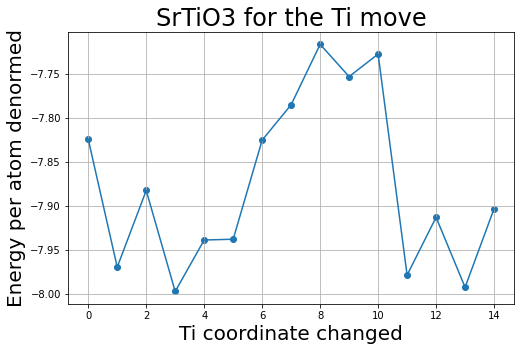

In [ ]:
import matplotlib.pyplot as plt # delta = 0.01

plt.figure(figsize = (8, 5))
plt.plot(denormed_test_prediction)
plt.scatter(range(15), denormed_test_prediction)

plt.title('SrTiO3 for the Ti move', size = 24)
plt.xlabel('Ti coordinate changed', size = 20)
plt.ylabel('Energy per atom denormed', size = 20)
plt.grid(True)
plt.show()

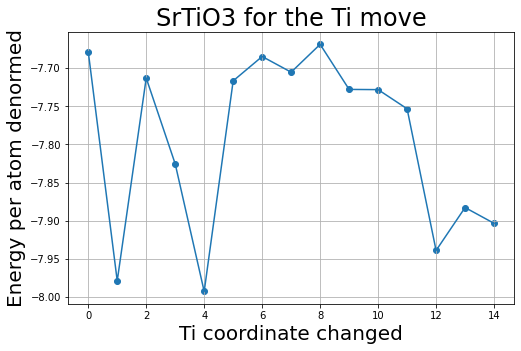

In [ ]:
import matplotlib.pyplot as plt # delta = 0.02

plt.figure(figsize = (8, 5))
plt.plot(denormed_test_prediction)
plt.scatter(range(15), denormed_test_prediction)

plt.title('SrTiO3 for the Ti move', size = 24)
plt.xlabel('Ti coordinate changed', size = 20)
plt.ylabel('Energy per atom denormed', size = 20)
plt.grid(True)
plt.show()

## Conclusion

1. SrTiO3의 Ti 원자의 유닛셀 안에서의 위치를 변화시키며 이에 따른 energy per atom 물성값의 변화 곡선 그리기를 시도
2. 모델이 제대로 예측한다면 DFT 결과와 모델의 추론값이 유사해야 한다.
3. 모델의 최종 output에 대해 normalizer.denorm(output)을 적용하여 되돌렸음. 
4. 실제 DFT 데이터에서는 어떤 양상이 나타나는지 추가로 계산하여 비교할 것!
